In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='my-project-dissertation-464420')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#This script consolidates all feature extraction from Earth Engine into a single, comprehensive master file.
# It handles both categorical and continuous peatland data, as well as other static and time-series features.
# This version uses a less efficient but more robust point-by-point extraction method.

import ee
import pandas as pd
import numpy as np

# --- 1. Authenticate and Initialize Earth Engine ---
try:
    ee.Initialize(project="my-project-dissertation-464420")
    print("Earth Engine initialized successfully.")
except Exception as e:
    try:
        ee.Authenticate()
        ee.Initialize(project="my-project-dissertation-464420")
        print("Authenticated and initialized Earth Engine.")
    except Exception as e2:
        print("Earth Engine initialization failed. Please ensure you have authenticated.")
        print(f"Error: {e2}")
        exit()

# --- 2. Load the Original CSV File ---
original_file = '/content/drive/MyDrive/rimba_raya_biomass_updated (3).csv'
try:
    df = pd.read_csv(original_file)
except FileNotFoundError:
    print(f"Error: The file '{original_file}' was not found.")
    print("Please upload this file to your Colab environment.")
    exit()

print(f"Original dataset loaded. Shape: {df.shape}")

# --- Remove the NDVI column if it exists ---
if 'NDVI' in df.columns:
    df = df.drop(columns=['NDVI'])
    print("NDVI column removed from the DataFrame.")

# --- 3. Define Earth Engine Datasets and Parameters ---
# Use a consistent scale for all extractions
extraction_scale = 8000

# Public asset IDs for all static and time-series features
# Static Datasets
clay_data = ee.Image("projects/soilgrids-isric/clay_mean").select('clay_0-5cm_mean')
sand_data = ee.Image("projects/soilgrids-isric/sand_mean").select('sand_0-5cm_mean')
silt_data = ee.Image("projects/soilgrids-isric/silt_mean").select('silt_0-5cm_mean')
elevation_data = ee.Image('CGIAR/SRTM90_V4').select('elevation')
peatland_fraction_data = ee.Image('projects/sat-io/open-datasets/ML-GLOBAL-PEATLAND-EXTENT').select('b1').rename('peatland_fraction')

# Time-series Datasets
gldas_groundwater_data = ee.ImageCollection('NASA/GLDAS/V022/CLSM/G025/DA1D').select('SoilMoist_RZ_tavg')
chirps_precip_data = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').select('precipitation')

# --- 4. Prepare the DataFrame for New Columns ---
df['soil_clay'] = np.nan
df['soil_sand'] = np.nan
df['soil_silt'] = np.nan
df['elevation'] = np.nan
df['peatland_fraction'] = np.nan
df['groundwater_depth'] = np.nan
df['total_precipitation'] = np.nan

# --- 5. Define a Function to Extract Features for a Single Point ---
def get_features_for_point(point_feature, year):
    """
    Extracts static and time-series features for a single point and year.
    Returns a dictionary of features.
    """
    lon = point_feature['lon']
    lat = point_feature['lat']
    gee_point = ee.Geometry.Point([lon, lat])

    start_date = ee.Date.fromYMD(int(year), 1, 1)
    end_date = ee.Date.fromYMD(int(year), 12, 31)

    # Helper function to safely get a value from a reduceRegion result
    def safe_get_info(ee_object, key):
        try:
            result_dict = ee_object.getInfo()
            if result_dict and key in result_dict:
                return result_dict[key]
            else:
                return None
        except Exception:
            # Silently pass errors for cases where no data is found
            return None

    # Static Data
    clay_value = safe_get_info(clay_data.reduceRegion(reducer=ee.Reducer.mean(), geometry=gee_point, scale=extraction_scale), 'clay_0-5cm_mean')
    sand_value = safe_get_info(sand_data.reduceRegion(reducer=ee.Reducer.mean(), geometry=gee_point, scale=extraction_scale), 'sand_0-5cm_mean')
    silt_value = safe_get_info(silt_data.reduceRegion(reducer=ee.Reducer.mean(), geometry=gee_point, scale=extraction_scale), 'silt_0-5cm_mean')
    elevation_value = safe_get_info(elevation_data.reduceRegion(reducer=ee.Reducer.mean(), geometry=gee_point, scale=extraction_scale), 'elevation')
    peatland_fraction_value = safe_get_info(peatland_fraction_data.reduceRegion(reducer=ee.Reducer.mean(), geometry=gee_point, scale=extraction_scale), 'peatland_fraction')

    # Time-series Data
    # Precipitation
    precip_collection = chirps_precip_data.filterDate(start_date, end_date).filterBounds(gee_point).select('precipitation')
    total_precipitation = None
    if precip_collection.size().getInfo() > 0:
        precip_image = precip_collection.sum()
        total_precipitation = safe_get_info(precip_image.reduceRegion(reducer=ee.Reducer.mean(), geometry=gee_point, scale=extraction_scale), 'precipitation')

    # Root_Zone_Soil_Moisture
    Root_Zone_Soil_Moisture_collection = gldas_groundwater_data.filterDate(start_date, end_date).filterBounds(gee_point).select('SoilMoist_RZ_tavg')
    root_zone_soil_moisture_value = None
    if Root_Zone_Soil_Moisture_collection.size().getInfo() > 0:
        Root_Zone_Soil_Moisture_image = Root_Zone_Soil_Moisture_collection.mean()
        root_zone_soil_moisture_value = safe_get_info(Root_Zone_Soil_Moisture_image.reduceRegion(reducer=ee.Reducer.mean(), geometry=gee_point, scale=extraction_scale), 'SoilMoist_RZ_tavg')


    # Combine all features into a dictionary
    features = {
        'soil_clay': clay_value,
        'soil_sand': sand_value,
        'soil_silt': silt_value,
        'elevation': elevation_value,
        'peatland_fraction': peatland_fraction_value,
        'groundwater_depth': root_zone_soil_moisture_value, # Corrected key name and variable
        'total_precipitation': total_precipitation
    }

    return features

# --- 6. Loop Through the DataFrame and Extract Features ---
print("\nStarting feature extraction loop...")
for index, row in df.iterrows():
    year = int(row['year'])

    # Get the new features for the point and year
    features = get_features_for_point(row, year)

    # Assign the features to the corresponding columns
    df.loc[index, 'soil_clay'] = features['soil_clay']
    df.loc[index, 'soil_sand'] = features['soil_sand']
    df.loc[index, 'soil_silt'] = features['soil_silt']
    df.loc[index, 'elevation'] = features['elevation']
    df.loc[index, 'peatland_fraction'] = features['peatland_fraction']
    df.loc[index, 'groundwater_depth'] = features['groundwater_depth'] # Corrected key name
    df.loc[index, 'total_precipitation'] = features['total_precipitation']

    # Provide an update every 50 points to track progress
    if (index + 1) % 50 == 0:
        print(f"Extracted features for {index + 1} points.")

print("\nFeature extraction complete.")
print(df.head())

# --- 7. Save the Master CSV File ---
output_file = 'rimba_raya_biomass_with_all_features_raw.csv'
df.to_csv(output_file, index=False)
print(f"\n✅ All features extracted and saved to '{output_file}'.")
print("\nFirst 5 rows of the new master file:")
print(df.head())

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


Authenticated and initialized Earth Engine.
Original dataset loaded. Shape: (140, 5)
NDVI column removed from the DataFrame.

Starting feature extraction loop...


Extracted features for 50 points.


Extracted features for 100 points.

Feature extraction complete.
        lat         lon  year        AGB  soil_clay  soil_sand  soil_silt  \
0 -2.541667  111.958333  1993  65.595014      369.0      280.0      353.0   
1 -2.541667  111.958333  1994  60.982519      369.0      280.0      353.0   
2 -2.541667  111.958333  1995  60.037519      369.0      280.0      353.0   
3 -2.541667  111.958333  1996  59.795021      369.0      280.0      353.0   
4 -2.541667  111.958333  1997  57.045010      369.0      280.0      353.0   

   elevation  peatland_fraction  groundwater_depth  total_precipitation  
0       25.0           3.298563                NaN          2915.452950  
1       25.0           3.298563                NaN          2624.599528  
2       25.0           3.298563                NaN          3164.151062  
3       25.0           3.298563                NaN          3016.043040  
4       25.0           3.298563                NaN          2037.598836  

✅ All features extracted an

In [ ]:
"""Feature Engineering """
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Load the CSV file
file_path = '/content/drive/MyDrive/rimba_raya_biomass_with_all_features_raw.csv'
df = pd.read_csv(file_path)

# Step 2: Split the data into training and test sets (80% training, 20% testing)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 3: Handle missing data for the 'groundwater_depth' column (impute using mean of training data)
train_df['groundwater_depth'].fillna(train_df['groundwater_depth'].mean(), inplace=True)
test_df['groundwater_depth'].fillna(train_df['groundwater_depth'].mean(), inplace=True)


# Step 4: Feature Engineering on the training set
# Create the new features
train_df['soil_silt/soil_clay'] = train_df['soil_silt'] / train_df['soil_clay']
train_df['elevation*precipitation'] = train_df['elevation'] * train_df['total_precipitation']
train_df['rootzone_soil_moisture/total_precipitation'] = train_df['groundwater_depth'] / train_df['total_precipitation']
train_df['std_rootzone_soil_moisture'] = train_df.groupby('year')['groundwater_depth'].transform('std')
train_df['range_precipitation'] = train_df.groupby('year')['total_precipitation'].transform('max') - train_df.groupby('year')['total_precipitation'].transform('min')
train_df['std_precipitation'] = train_df.groupby('year')['total_precipitation'].transform('std')
train_df['elevation*rootzone_soil_moisture'] = train_df['elevation'] * train_df['groundwater_depth']
train_df['log_elevation'] = train_df['elevation'].apply(lambda x: 0 if x == 0 else np.log(x))
train_df['log_AGB'] = train_df['AGB'].apply(lambda x: 0 if x == 0 else np.log(x))

# Apply the same feature engineering to the test set (using the test set's data)
test_df['soil_silt/soil_clay'] = test_df['soil_silt'] / test_df['soil_clay']
test_df['elevation*precipitation'] = test_df['elevation'] * test_df['total_precipitation']
test_df['rootzone_soil_moisture/total_precipitation'] = test_df['groundwater_depth'] / test_df['total_precipitation']
test_df['std_rootzone_soil_moisture'] = test_df.groupby('year')['groundwater_depth'].transform('std')
test_df['range_precipitation'] = test_df.groupby('year')['total_precipitation'].transform('max') - test_df.groupby('year')['total_precipitation'].transform('min')
test_df['std_precipitation'] = test_df.groupby('year')['total_precipitation'].transform('std')
test_df['elevation*rootzone_soil_moisture'] = test_df['elevation'] * test_df['groundwater_depth']
test_df['log_elevation'] = test_df['elevation'].apply(lambda x: 0 if x == 0 else np.log(x))
test_df['log_AGB'] = test_df['AGB'].apply(lambda x: 0 if x == 0 else np.log(x))

### Step 5: Add Categorization (New Step)
# Create a list of columns to categorize
columns_to_categorize = ['soil_silt', 'soil_clay', 'soil_sand']

# Loop through each column to apply categorization
for col in columns_to_categorize:
    try:
        # Use pd.qcut() on the training data to get the bin edges and labels
        # Use duplicates='drop' to handle cases with fewer unique values than q
        train_df[f'{col}_group'], bins = pd.qcut(
            train_df[col],
            q=3,
            labels=['low', 'medium', 'high'],
            retbins=True,
            duplicates='drop'
        )

        # Ensure the number of bins matches the number of labels before applying to test data
        if len(bins) - 1 == len(['low', 'medium', 'high']):
            # Use pd.cut() with the same bins to categorize the test data
            test_df[f'{col}_group'] = pd.cut(
                test_df[col],
                bins=bins,
                labels=['low', 'medium', 'high']
            )
        else:
            print(f"Warning: Could not create 3 unique bins for '{col}' in the training data. Skipping categorization for this column in the test set.")
            test_df[f'{col}_group'] = None # Or some other placeholder

    except ValueError as e:
        print(f"Could not categorize {col}: {e}")


# Step 5: Normalize the data using StandardScaler (fit on training data and apply to both train and test)
scaler = StandardScaler()

# Fit and transform the training set
train_df[['soil_silt', 'soil_clay', 'elevation']] = scaler.fit_transform(train_df[['soil_silt', 'soil_clay', 'elevation']])

# Transform the test set using the same scaler (without fitting again)
test_df[['soil_silt', 'soil_clay', 'elevation']] = scaler.transform(test_df[['soil_silt', 'soil_clay', 'elevation']])

# Step 6: Check the results of the feature engineering on both sets
print("Training Set with New Features:")
print(train_df[['lat', 'lon', 'year', 'soil_silt/soil_clay', 'elevation*precipitation', 'rootzone_soil_moisture/total_precipitation']].head())

print("\nTest Set with New Features:")
print(test_df[['lat', 'lon', 'year', 'soil_silt/soil_clay', 'elevation*precipitation', 'rootzone_soil_moisture/total_precipitation']].head())

df_updated = pd.concat([train_df, test_df], axis=0)

# Step 3: Save the updated dataframe to a new CSV file
# The original code with the full Google Drive path
# output_file_path = '/content/drive/MyDrive/rimba_raya_biomass_with_all_features_raw_updated.csv'

# Step 8: Save the updated dataframes to separate CSV files to prevent data leakage
train_output_path = 'rimba_raya_biomass_train_processed.csv'
test_output_path = 'rimba_raya_biomass_test_processed.csv'

train_df.to_csv(train_output_path, index=False)
test_df.to_csv(test_output_path, index=False)

Training Set with New Features:
          lat         lon  year  soil_silt/soil_clay  elevation*precipitation  \
16  -2.541667  111.958333  2009             0.956640             68967.687877   
18  -2.541667  111.958333  2011             0.956640             79088.220569   
10  -2.541667  111.958333  2003             0.956640             68028.964806   
111 -2.625000  112.041667  2020             0.892388            187497.937622   
101 -2.625000  112.041667  2010             0.892388            209899.224768   

     rootzone_soil_moisture/total_precipitation  
16                                     0.079941  
18                                     0.068316  
10                                     0.083646  
111                                    0.091975  
101                                    0.084690  

Test Set with New Features:
          lat         lon  year  soil_silt/soil_clay  elevation*precipitation  \
108 -2.625000  112.041667  2017             0.892388            157649.

/tmp/ipython-input-551072085.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['groundwater_depth'].fillna(train_df['groundwater_depth'].mean(), inplace=True)
/tmp/ipython-input-551072085.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[c

AGB                                           1.000000
elevation                                     0.780211
elevation*rootzone_soil_moisture              0.700655
elevation*precipitation                       0.605590
soil_sand                                     0.350267
soil_clay                                     0.300735
rootzone_soil_moisture/total_precipitation    0.173572
groundwater_depth                             0.142786
peatland_fraction                             0.059571
range_precipitation                          -0.038221
total_precipitation                          -0.046262
std_precipitation                            -0.048492
std_rootzone_soil_moisture                   -0.122088
year                                         -0.198166
lat                                          -0.301704
lon                                          -0.344864
soil_silt                                    -0.571865
soil_silt/soil_clay                          -0.602028
Name: AGB,

/tmp/ipython-input-2451367536.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_agb.values, y=corr_with_agb.index, palette="viridis")


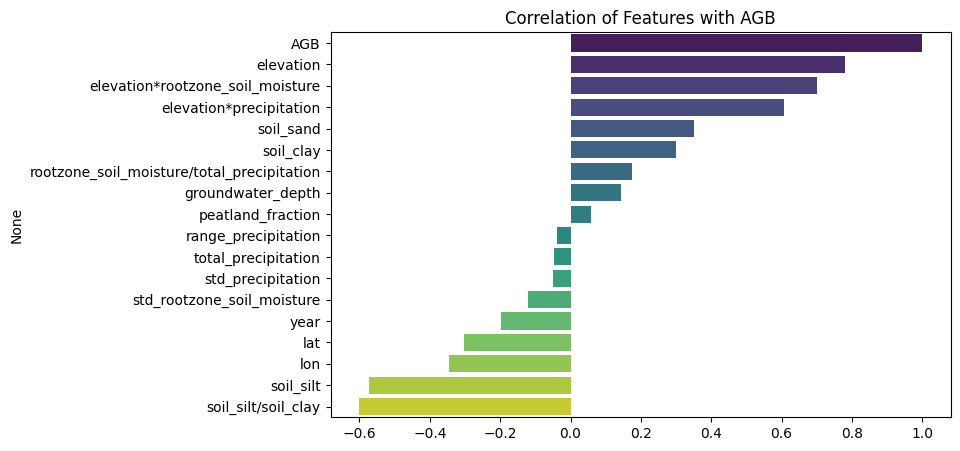

Spearman correlation:
 AGB                                           1.000000
elevation                                     0.536671
elevation*rootzone_soil_moisture              0.491293
elevation*precipitation                       0.404108
soil_sand                                     0.402770
rootzone_soil_moisture/total_precipitation    0.183415
groundwater_depth                             0.047970
range_precipitation                          -0.043993
std_precipitation                            -0.062025
total_precipitation                          -0.080603
std_rootzone_soil_moisture                   -0.089216
soil_clay                                    -0.093648
peatland_fraction                            -0.158680
year                                         -0.179378
lon                                          -0.205641
soil_silt/soil_clay                          -0.331019
lat                                          -0.398832
soil_silt                                 

/tmp/ipython-input-2451367536.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="magma")


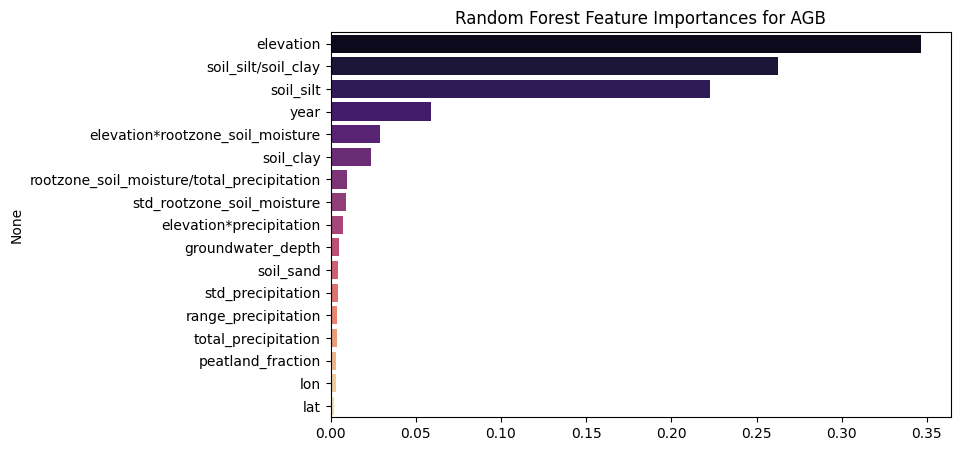

In [ ]:
file_path_train = '/content/drive/MyDrive/rimba_raya_biomass_train_processed.csv'
file_path_test = '/content/drive/MyDrive/rimba_raya_biomass_test_processed.csv'
df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

# Impute missing values with mean
df_train = df_train.fillna(df_train.mean(numeric_only=True))
df_test = df_test.fillna(df_test.mean(numeric_only=True))

import seaborn as sns
import matplotlib.pyplot as plt

# Pearson correlation
corr_matrix = df_train.corr(numeric_only=True)
corr_with_agb = corr_matrix["AGB"].sort_values(ascending=False)
print(corr_with_agb)

# Plot correlations with AGB
plt.figure(figsize=(8,5))
sns.barplot(x=corr_with_agb.values, y=corr_with_agb.index, palette="viridis")
plt.title("Correlation of Features with AGB")
plt.show()

# Spearman correlation (rank-based, good for monotonic relationships)
spearman_corr = df_train.corr(method="spearman", numeric_only=True)["AGB"].sort_values(ascending=False)
print("Spearman correlation:\n", spearman_corr)

# Features and target
X_train = df_train.drop(columns=["AGB", "soil_silt_group", "soil_clay_group", "soil_sand_group"])
y_train = df_train["AGB"]

X_test = df_test.drop(columns=["AGB", "soil_silt_group", "soil_clay_group", "soil_sand_group"])
y_test = df_test["AGB"]

# Import necessary modules for modeling and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# --- Linear Regression ---
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_train_lr = linreg.predict(X_train)
y_pred_test_lr = linreg.predict(X_test)

print("\nLinear Regression Performance:")
print("Train R²:", r2_score(y_train, y_pred_train_lr))
print("Test R²:", r2_score(y_test, y_pred_test_lr))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test_lr)))

# --- Random Forest Regressor ---
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

print("\nRandom Forest Performance:")
print("Train R²:", r2_score(y_train, y_pred_train_rf))
print("Test R²:", r2_score(y_test, y_pred_test_rf))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test_rf)))

# ========================
# 5. Feature Importance (Random Forest)
# ========================
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index, palette="magma")
plt.title("Random Forest Feature Importances for AGB")
plt.show()


--- Outer Fold 1 ---
  Tuning Random Forest...
    Best RF params: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}
  Tuning XGBoost...
    Best XGBoost params: {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.7}
  Tuning SVR...
    Best SVR params: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
  Training Neural Network...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    NN training complete.
  Evaluating Base Models on Outer Test Fold...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
  Generating OOF predictions for meta-model training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
  Training Ridge Meta-Model (No NN)...
  Training Ridge Meta-Model...
  Training Decision Tree Meta-Model...
  Evaluating Stacked Models on Outer Test Fold...

--- Outer Fold 2 ---
  Tuning Random Forest...
    Best RF params: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
  Tuning XGBoost...
    Best XGBoost params: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.7}
  Tuning SVR...
    Best SVR params: {'C': 10, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'linear'}
  Training Neural Network...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    NN training complete.
  Evaluating Base Models on Outer Test Fold...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
  Generating OOF predictions for meta-model training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
  Training Ridge Meta-Model (No NN)...
  Training Ridge Meta-Model...
  Training Decision Tree Meta-Model...
  Evaluating Stacked Models on Outer Test Fold...

--- Outer Fold 3 ---
  Tuning Random Forest...
    Best RF params: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}
  Tuning XGBoost...
    Best XGBoost params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 1}
  Tuning SVR...
    Best SVR params: {'C': 10, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'linear'}
  Training Neural Network...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    NN training complete.
  Evaluating Base Models on Outer Test Fold...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
  Generating OOF predictions for meta-model training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
  Training Ridge Meta-Model (No NN)...
  Training Ridge Meta-Model...
  Training Decision Tree Meta-Model...
  Evaluating Stacked Models on Outer Test Fold...

--- Outer Fold 4 ---
  Tuning Random Forest...
    Best RF params: {'bootstrap': True, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}
  Tuning XGBoost...
    Best XGBoost params: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.7}
  Tuning SVR...
    Best SVR params: {'C': 10, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'linear'}
  Training Neural Network...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    NN training complete.
  Evaluating Base Models on Outer Test Fold...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
  Generating OOF predictions for meta-model training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
  Training Ridge Meta-Model (No NN)...
  Training Ridge Meta-Model...
  Training Decision Tree Meta-Model...
  Evaluating Stacked Models on Outer Test Fold...

--- Outer Fold 5 ---
  Tuning Random Forest...
    Best RF params: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}
  Tuning XGBoost...
    Best XGBoost params: {'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.7}
  Tuning SVR...
    Best SVR params: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
  Training Neural Network...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    NN training complete.
  Evaluating Base Models on Outer Test Fold...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
  Generating OOF predictions for meta-model training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
  Training Ridge Meta-Model (No NN)...
  Training Ridge Meta-Model...
  Training Decision Tree Meta-Model...
  Evaluating Stacked Models on Outer Test Fold...

✅ Final predictions saved to 'final_predictions.csv'.

--- Nested Cross-Validation Results ---
Random Forest:
  RMSE: 7.646 ± 1.705
  R²: 0.915 ± 0.056
  MAE: 5.418 ± 1.454
  Bias: -0.093 ± 2.148
XGBoost:
  RMSE: 7.590 ± 1.627
  R²: 0.912 ± 0.064
  MAE: 5.489 ± 1.295
  Bias: -0.045 ± 1.952
SVR:
  RMSE: 11.450 ± 2.458
  R²: 0.818 ± 0.105
  MAE: 8.787 ± 1.651
  Bias: -1.898 ± 3.484
Neural Network:
  RMSE: 13.081 ± 1.688
  R²: 0.759 ± 0.157
  MAE: 10.248 ± 1.195
  Bias: 1.197 ± 2.526
Ridge Stacked:
  RMSE: 7.868 ± 2.329
  R²: 0.901 ± 0.079
  MAE: 5.658 ± 1.769
  Bias: 1.290 ± 2.874
DT Stacked:
  RMSE: 12.055 ± 4.482
  R²: 0.791 ± 0.162
  MAE: 9.402 ± 3.561
  Bias: 2.215 ± 3.380
Ridge Stacked (No NN):
  RMSE: 7.562 ± 1.692
  R²: 0.912 ± 0.066
  MAE: 5.437 ± 1.296
  Bias: -0.118 ± 2.068

✅ Nested

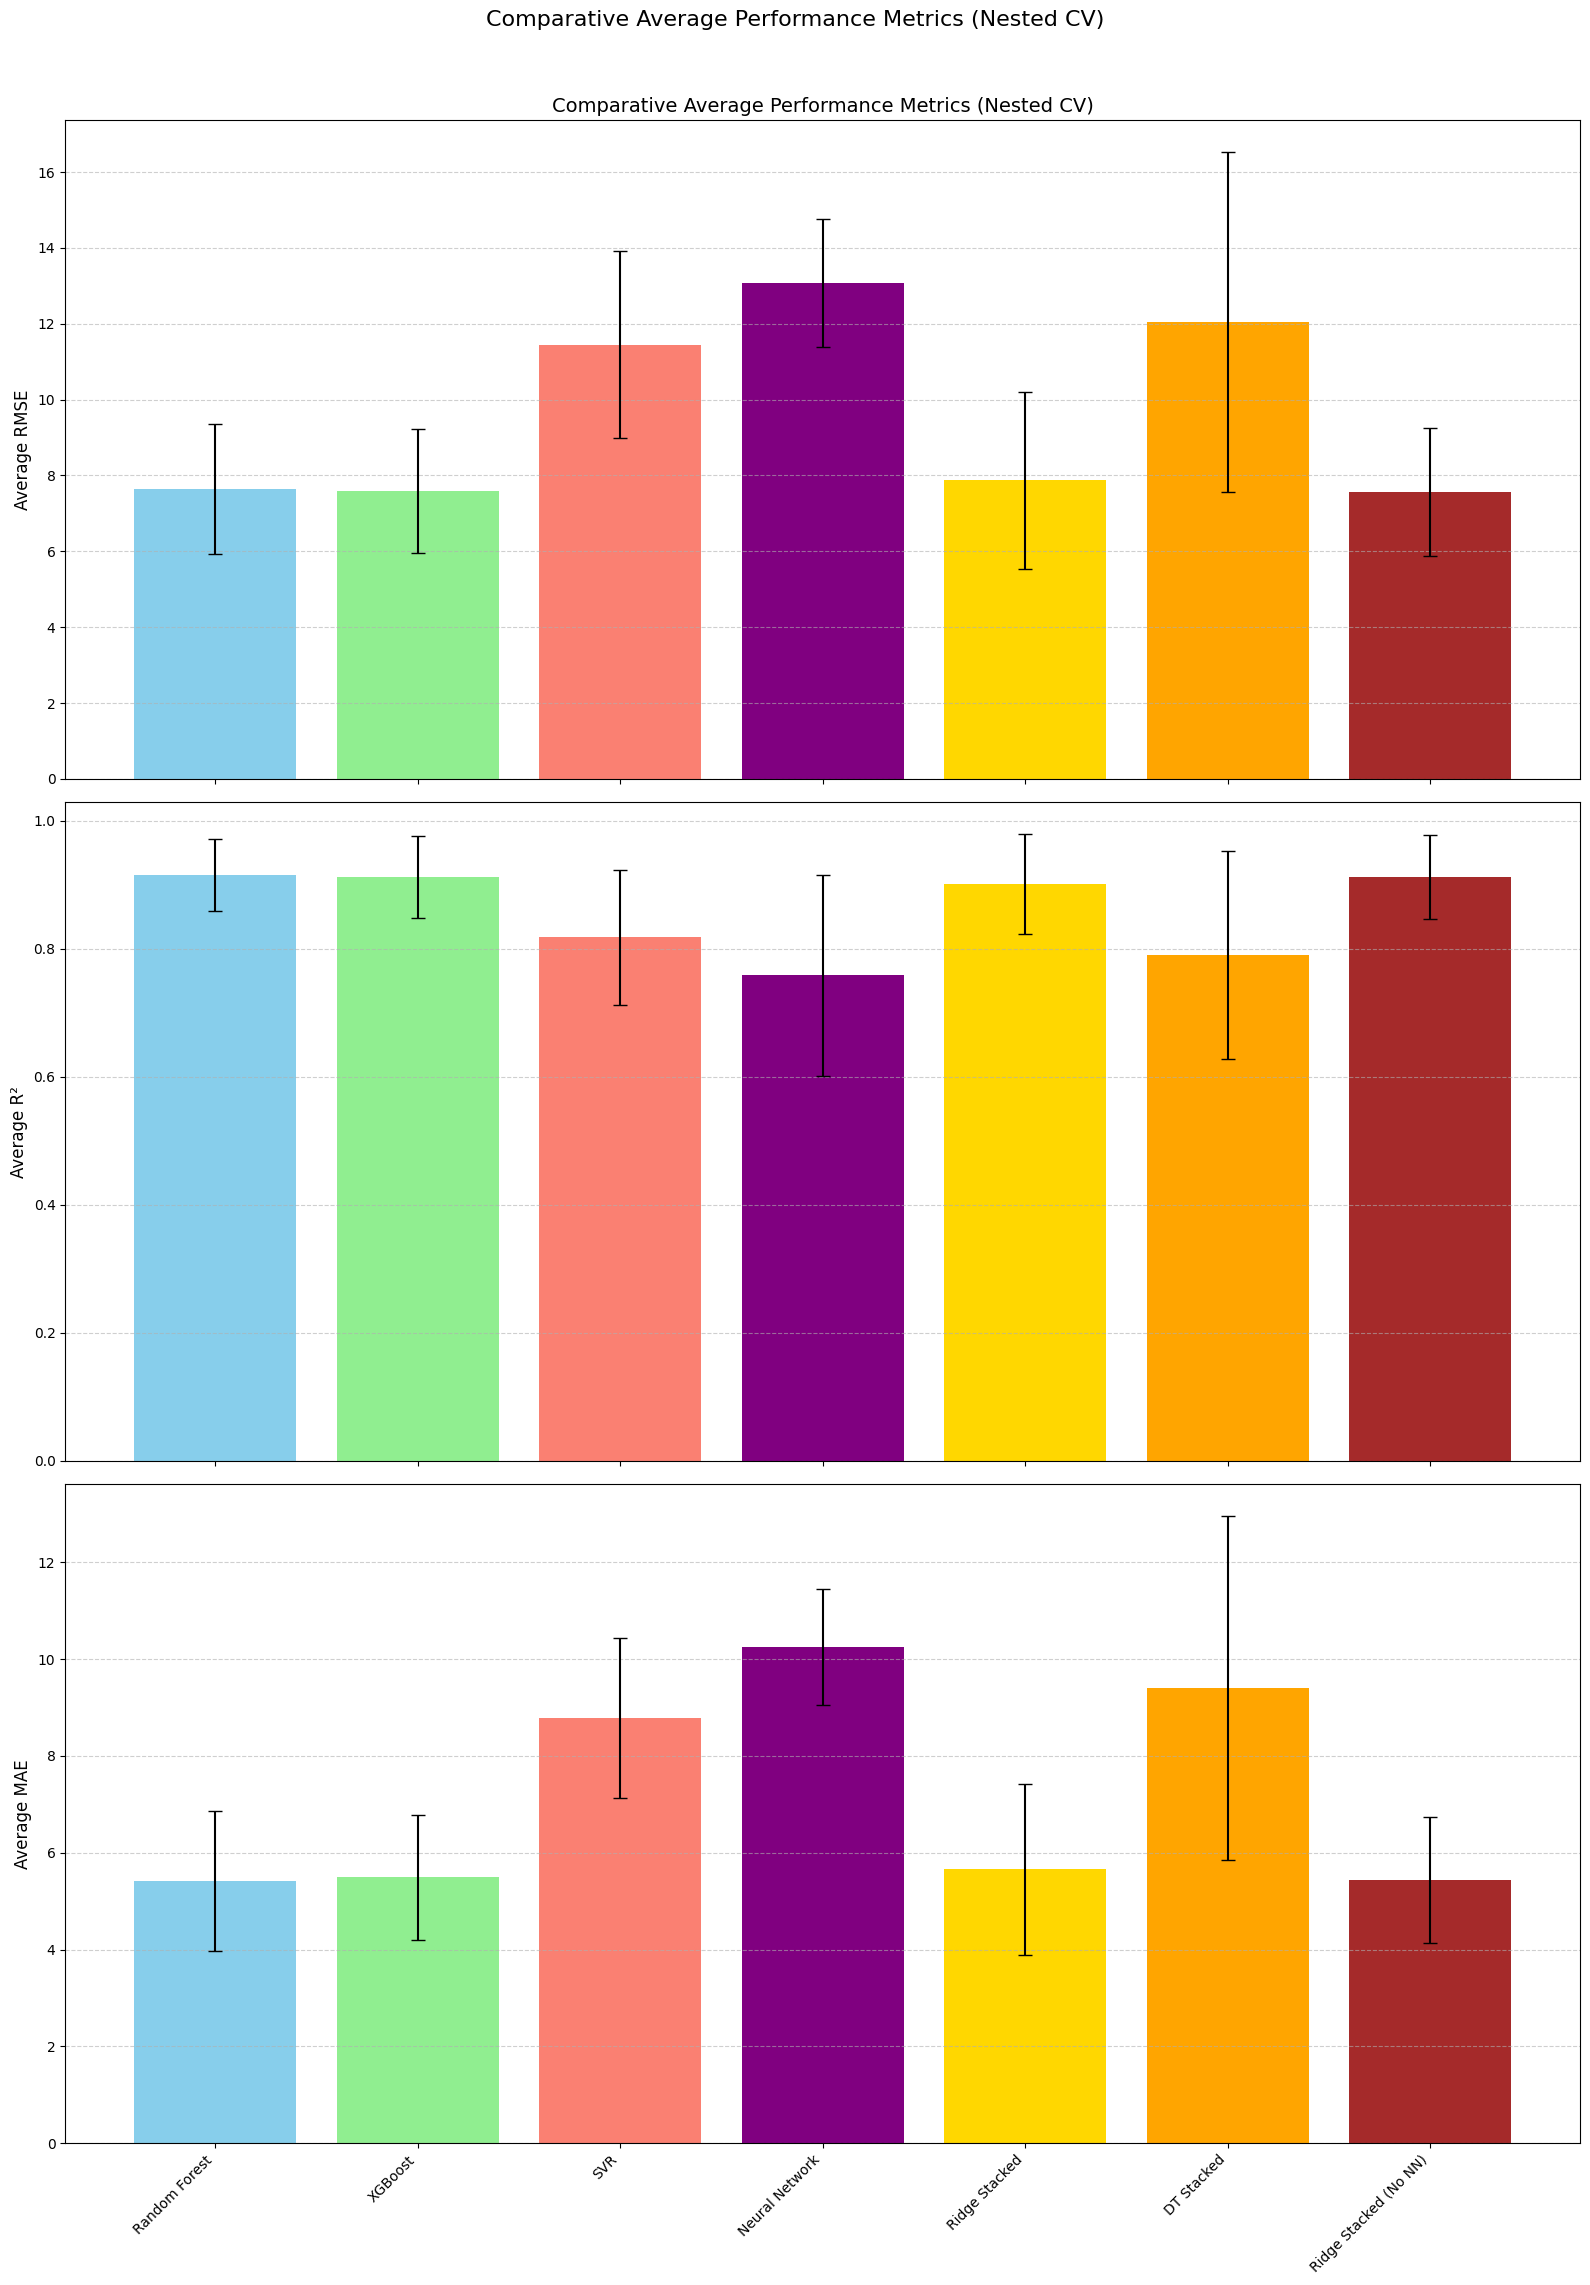


✅ Comparative bias plot saved as 'Comparative_Bias_NestedCV.png'.


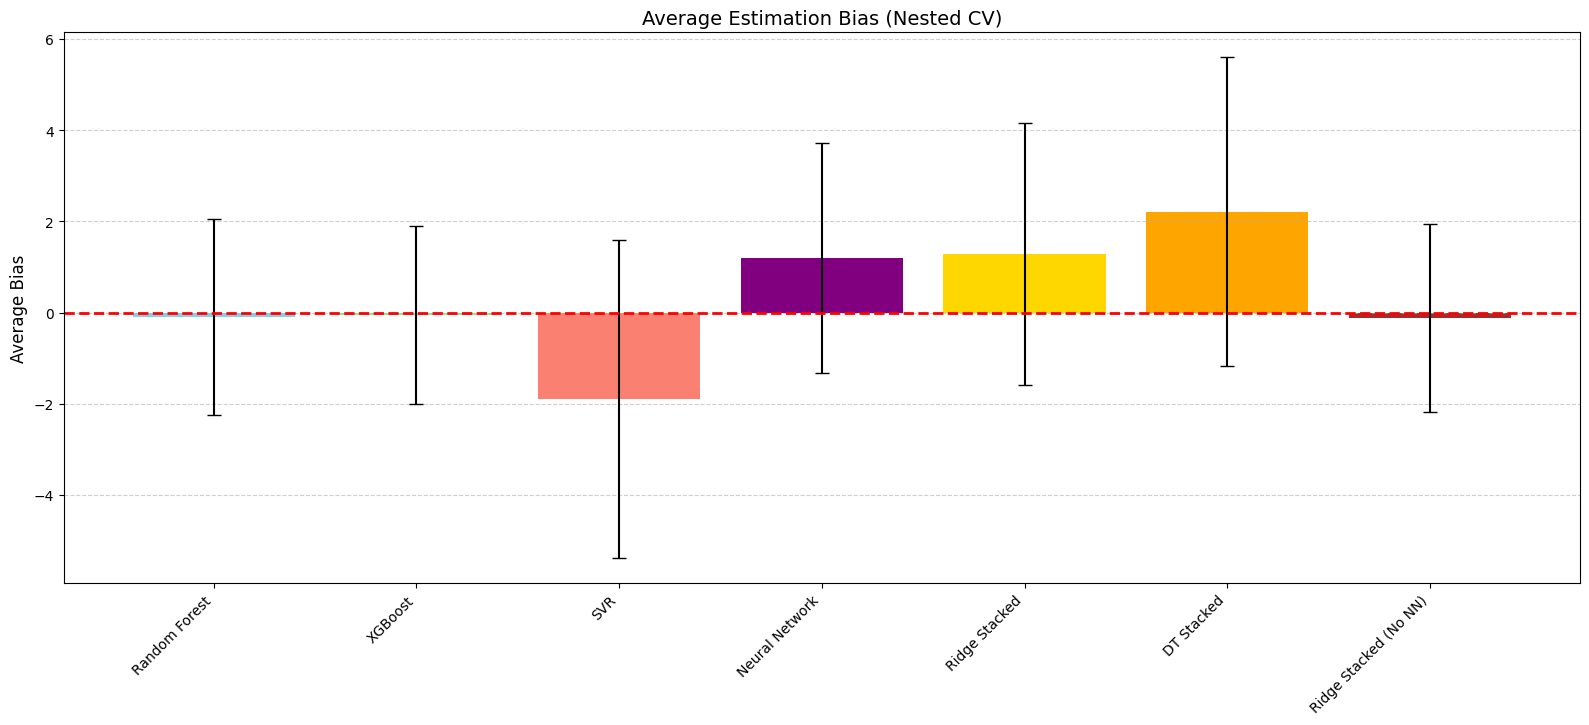


Training final base models on the full dataset...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


...Final base models trained.
Generating OOF predictions for final meta-model training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
...OOF predictions generated.
Training final Ridge Meta-Model (No NN) on OOF predictions...
Training final meta-models on OOF predictions...
...Final meta-models trained.

✅ Final meta-models saved.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import StackingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.base import clone # Import clone
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression # Import Ridge and LinearRegression

# ------------------------------------
# 1. Load preprocessed train and test sets
# ------------------------------------
train_df = pd.read_csv('/content/drive/MyDrive/rimba_raya_biomass_train_processed.csv')
test_df = pd.read_csv('/content/drive/MyDrive/rimba_raya_biomass_test_processed.csv')

# Separate features and target from the combined dataset for nested CV
X = pd.concat([train_df.drop('AGB', axis=1), test_df.drop('AGB', axis=1)], ignore_index=True)
y = pd.concat([train_df['AGB'], test_df['AGB']], ignore_index=True)


# ------------------------------------
# 2. Define the Neural Network model function
# ------------------------------------
def create_nn_model(input_dim):
    """
    Creates a compiled Keras Sequential model for regression.

    Args:
        input_dim: The number of input features.

    Returns:
        A compiled Keras Sequential model.
    """
    nn_model = Sequential()
    # Input + first hidden layer
    nn_model.add(Dense(64, activation='relu', input_dim=input_dim))
    # Second hidden layer
    nn_model.add(Dense(32, activation='relu'))
    # Output layer for regression
    nn_model.add(Dense(1, activation='linear'))
    nn_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='mean_squared_error',
                     metrics=['mae'])
    return nn_model

# ------------------------------------
# New Function: Calculate Bias
# ------------------------------------
def calculate_bias(y_true, y_pred):
    """Calculates the mean estimation bias based on the paper's formula."""
    return np.mean(y_true - y_pred)


# ------------------------------------
# 3. Define base models and their parameter grids
# (Assuming these are defined in a previous cell, if not, uncomment and define)
# ------------------------------------
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'random_state': [42]
}

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.7, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'random_state': [42]
}

svr_params = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

# ------------------------------------
# 4. Implement Nested Cross-Validation
# ------------------------------------
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42) # Inner CV for tuning

# Lists to store results for each model across outer folds
rf_rmse_outer, rf_r2_outer, rf_mae_outer, rf_bias_outer = [], [], [], []
xgb_rmse_outer, xgb_r2_outer, xgb_mae_outer, xgb_bias_outer = [], [], [], []
svr_rmse_outer, svr_r2_outer, svr_mae_outer, svr_bias_outer = [], [], [], []
nn_rmse_outer, nn_r2_outer, nn_mae_outer, nn_bias_outer = [], [], [], []
stacked_ridge_rmse_outer, stacked_ridge_r2_outer, stacked_ridge_mae_outer, stacked_ridge_bias_outer = [], [], [], []
stacked_dt_rmse_outer, stacked_dt_r2_outer, stacked_dt_mae_outer, stacked_dt_bias_outer = [], [], [], []
# New list for the stacked model without NN
stacked_ridge_no_nn_rmse_outer, stacked_ridge_no_nn_r2_outer, stacked_ridge_no_nn_mae_outer, stacked_ridge_no_nn_bias_outer = [], [], [], []


# Iterate through the outer cross-validation folds
for fold, (train_index_outer, test_index_outer) in enumerate(outer_cv.split(X, y)):
    print(f"\n--- Outer Fold {fold+1} ---")
    X_train_outer, X_test_outer = X.iloc[train_index_outer], X.iloc[test_index_outer]
    y_train_outer, y_test_outer = y.iloc[train_index_outer], y.iloc[test_index_outer]

    # Identify numerical and categorical columns
    numerical_cols = X_train_outer.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X_train_outer.select_dtypes(exclude=np.number).columns.tolist()


    # Preprocessing within the outer fold (fit on outer train, transform outer train and test)
    # Impute missing numerical values
    imputer_outer = SimpleImputer(strategy='mean')
    X_train_outer_numerical_imp = imputer_outer.fit_transform(X_train_outer[numerical_cols])
    X_test_outer_numerical_imp = imputer_outer.transform(X_test_outer[numerical_cols])

    # Scale numerical features
    scaler_outer = StandardScaler()
    X_train_outer_scaled = scaler_outer.fit_transform(X_train_outer_numerical_imp)
    X_test_outer_scaled = scaler_outer.transform(X_test_outer_numerical_imp)

    # Convert scaled numerical arrays back to DataFrames, preserving original indices and numerical column names
    X_train_outer_scaled_df = pd.DataFrame(X_train_outer_scaled, columns=numerical_cols, index=train_index_outer)
    X_test_outer_scaled_df = pd.DataFrame(X_test_outer_scaled, columns=numerical_cols, index=test_index_outer)

    # Recombine with categorical columns
    X_train_outer_processed = pd.concat([X_train_outer_scaled_df, X_train_outer[categorical_cols]], axis=1)
    X_test_outer_processed = pd.concat([X_test_outer_scaled_df, X_test_outer[categorical_cols]], axis=1)

    # Handle potential NaNs in categorical columns if necessary for models (e.g., fill with a placeholder or use a model that handles NaNs)
    # For simplicity here, assuming models can handle NaNs in categorical features or they are not used directly in some models.
    # If using models sensitive to NaNs in categorical features, consider a strategy like filling with a placeholder:
    # X_train_outer_processed[categorical_cols] = X_train_outer_processed[categorical_cols].fillna('missing')
    # X_test_outer_processed[categorical_cols] = X_test_outer_processed[categorical_cols].fillna('missing')


    # --- Inner Cross-Validation for Hyperparameter Tuning (on X_train_outer_processed) ---

    # Random Forest Tuning - Use only numerical features for models that don't handle categorical strings directly
    print("  Tuning Random Forest...")
    rf = RandomForestRegressor(random_state=42)
    # Exclude categorical columns for models that can't handle them
    rf_grid = GridSearchCV(rf, rf_params, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    rf_grid.fit(X_train_outer_processed[numerical_cols], y_train_outer)
    rf_best = rf_grid.best_estimator_
    print("    Best RF params:", rf_grid.best_params_)

    # XGBoost Tuning - XGBoost can handle categorical features if they are appropriately encoded (e.g., one-hot or ordinal)
    # For now, let's exclude them for simplicity, assuming they are not the primary features for these models.
    print("  Tuning XGBoost...")
    xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
    xgb_grid = GridSearchCV(xgb, xgb_params, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    xgb_grid.fit(X_train_outer_processed[numerical_cols], y_train_outer)
    xgb_best = xgb_grid.best_estimator_
    print("    Best XGBoost params:", xgb_grid.best_params_)

    # SVR Tuning - SVR typically requires numerical input
    print("  Tuning SVR...")
    svr = SVR()
    svr_grid = GridSearchCV(svr, svr_params, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    svr_grid.fit(X_train_outer_processed[numerical_cols], y_train_outer)
    svr_best = svr_grid.best_estimator_
    print("    Best SVR params:", svr_grid.best_params_)

    # Neural Network Training (Simplified: train with fixed architecture on outer train fold)
    # NN also requires numerical input
    print("  Training Neural Network...")
    nn_best = create_nn_model(X_train_outer_processed[numerical_cols].shape[1])
    # Use validation_data to monitor performance on a subset of the outer training fold
    X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
        X_train_outer_processed[numerical_cols], y_train_outer, test_size=0.2, random_state=42
    )
    nn_best.fit(X_train_nn, y_train_nn, epochs=100, batch_size=32, verbose=0, validation_data=(X_val_nn, y_val_nn))
    print("    NN training complete.")


    # --- Evaluate Base Models on Outer Test Fold ---
    print("  Evaluating Base Models on Outer Test Fold...")
    # Predict using only numerical features for models that require it
    rf_preds_outer = rf_best.predict(X_test_outer_processed[numerical_cols])
    xgb_preds_outer = xgb_best.predict(X_test_outer_processed[numerical_cols])
    svr_preds_outer = svr_best.predict(X_test_outer_processed[numerical_cols])
    nn_preds_outer = nn_best.predict(X_test_outer_processed[numerical_cols]).flatten()

    # Calculate and store metrics for base models
    rf_rmse_outer.append(np.sqrt(mean_squared_error(y_test_outer, rf_preds_outer)))
    rf_r2_outer.append(r2_score(y_test_outer, rf_preds_outer))
    rf_mae_outer.append(mean_absolute_error(y_test_outer, rf_preds_outer))
    rf_bias_outer.append(calculate_bias(y_test_outer, rf_preds_outer)) # Calculate and store BIAS

    xgb_rmse_outer.append(np.sqrt(mean_squared_error(y_test_outer, xgb_preds_outer)))
    xgb_r2_outer.append(r2_score(y_test_outer, xgb_preds_outer))
    xgb_mae_outer.append(mean_absolute_error(y_test_outer, xgb_preds_outer))
    xgb_bias_outer.append(calculate_bias(y_test_outer, xgb_preds_outer)) # Calculate and store BIAS

    svr_rmse_outer.append(np.sqrt(mean_squared_error(y_test_outer, svr_preds_outer)))
    svr_r2_outer.append(r2_score(y_test_outer, svr_preds_outer))
    svr_mae_outer.append(mean_absolute_error(y_test_outer, svr_preds_outer))
    svr_bias_outer.append(calculate_bias(y_test_outer, svr_preds_outer)) # Calculate and store BIAS

    nn_rmse_outer.append(np.sqrt(mean_squared_error(y_test_outer, nn_preds_outer)))
    nn_r2_outer.append(r2_score(y_test_outer, nn_preds_outer))
    nn_mae_outer.append(mean_absolute_error(y_test_outer, nn_preds_outer))
    nn_bias_outer.append(calculate_bias(y_test_outer, nn_preds_outer)) # Calculate and store BIAS


    # --- Train Stacked Models on Outer Training Fold OOF Predictions ---
    # Generate OOF predictions from base models on the outer training fold
    X_meta_train_outer = pd.DataFrame()
    X_meta_test_outer = pd.DataFrame()
    y_meta_train_outer = y_train_outer.copy()

    oof_cv_inner = KFold(n_splits=5, shuffle=True, random_state=42)

    rf_oof_outer = np.zeros(len(X_train_outer_processed))
    xgb_oof_outer = np.zeros(len(X_train_outer_processed))
    svr_oof_outer = np.zeros(len(X_train_outer_processed))
    nn_oof_outer = np.zeros(len(X_train_outer_processed))


    print("  Generating OOF predictions for meta-model training...")
    for inner_train_index, inner_val_index in oof_cv_inner.split(X_train_outer_processed[numerical_cols], y_train_outer):
        X_inner_train, X_inner_val = X_train_outer_processed[numerical_cols].iloc[inner_train_index], X_train_outer_processed[numerical_cols].iloc[inner_val_index]
        y_inner_train, y_inner_val = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_val_index]

        # Train base models on inner training fold
        rf_oof_model = clone(rf_best).fit(X_inner_train, y_inner_train)
        xgb_oof_model = clone(xgb_best).fit(X_inner_train, y_inner_train)
        svr_oof_model = clone(svr_best).fit(X_inner_train, y_inner_train) # Corrected to use y_inner_train
        nn_oof_model = create_nn_model(X_inner_train.shape[1])
        nn_oof_model.fit(X_inner_train, y_inner_train, epochs=50, batch_size=32, verbose=0)

        # Predict on inner validation fold
        rf_oof_outer[inner_val_index] = rf_oof_model.predict(X_inner_val)
        xgb_oof_outer[inner_val_index] = xgb_oof_model.predict(X_inner_val)
        svr_oof_outer[inner_val_index] = svr_oof_model.predict(X_inner_val)
        nn_oof_outer[inner_val_index] = nn_oof_model.predict(X_inner_val).flatten()

    # Create meta-features for meta-model training
    X_meta_train_outer['rf_oof'] = rf_oof_outer
    X_meta_train_outer['xgb_oof'] = xgb_oof_outer
    X_meta_train_outer['svr_oof'] = svr_oof_outer
    X_meta_train_outer['nn_oof'] = nn_oof_outer

    # Create meta-features for prediction on the outer test fold
    X_meta_test_outer['rf_oof'] = rf_preds_outer
    X_meta_test_outer['xgb_oof'] = xgb_preds_outer
    X_meta_test_outer['svr_oof'] = svr_preds_outer
    X_meta_test_outer['nn_oof'] = nn_preds_outer

    # --- Train the new Stacked Model (Ridge with RF, XGBoost, SVR only) ---
    X_meta_train_outer_no_nn = X_meta_train_outer[['rf_oof', 'xgb_oof', 'svr_oof']]
    X_meta_test_outer_no_nn = X_meta_test_outer[['rf_oof', 'xgb_oof', 'svr_oof']]

    print("  Training Ridge Meta-Model (No NN)...")
    ridge_meta_model_no_nn = Ridge(alpha=1.0)
    ridge_meta_model_no_nn.fit(X_meta_train_outer_no_nn, y_meta_train_outer)

    # Train the other meta-models (Ridge and Decision Tree) on the OOF predictions
    print("  Training Ridge Meta-Model...")
    ridge_meta_model = Ridge(alpha=1.0)
    ridge_meta_model.fit(X_meta_train_outer, y_meta_train_outer)

    print("  Training Decision Tree Meta-Model...")
    dt_meta_model = DecisionTreeRegressor(random_state=42)
    dt_meta_model.fit(X_meta_train_outer, y_meta_train_outer)


    # --- Evaluate Stacked Models on Outer Test Fold ---
    print("  Evaluating Stacked Models on Outer Test Fold...")
    stacked_ridge_preds_outer = ridge_meta_model.predict(X_meta_test_outer)
    stacked_dt_preds_outer = dt_meta_model.predict(X_meta_test_outer)
    # Predict using the new stacked model (no NN)
    stacked_ridge_no_nn_preds_outer = ridge_meta_model_no_nn.predict(X_meta_test_outer_no_nn)

    # Calculate and store metrics for stacked models
    stacked_ridge_rmse_outer.append(np.sqrt(mean_squared_error(y_test_outer, stacked_ridge_preds_outer)))
    stacked_ridge_r2_outer.append(r2_score(y_test_outer, stacked_ridge_preds_outer))
    stacked_ridge_mae_outer.append(mean_absolute_error(y_test_outer, stacked_ridge_preds_outer))
    stacked_ridge_bias_outer.append(calculate_bias(y_test_outer, stacked_ridge_preds_outer)) # Calculate and store BIAS

    stacked_dt_rmse_outer.append(np.sqrt(mean_squared_error(y_test_outer, stacked_dt_preds_outer)))
    stacked_dt_r2_outer.append(r2_score(y_test_outer, stacked_dt_preds_outer))
    stacked_dt_mae_outer.append(mean_absolute_error(y_test_outer, stacked_dt_preds_outer))
    stacked_dt_bias_outer.append(calculate_bias(y_test_outer, stacked_dt_preds_outer)) # Calculate and store BIAS

    # Calculate and store metrics for the new stacked model (no NN)
    stacked_ridge_no_nn_rmse_outer.append(np.sqrt(mean_squared_error(y_test_outer, stacked_ridge_no_nn_preds_outer)))
    stacked_ridge_no_nn_r2_outer.append(r2_score(y_test_outer, stacked_ridge_no_nn_preds_outer))
    stacked_ridge_no_nn_mae_outer.append(mean_absolute_error(y_test_outer, stacked_ridge_no_nn_preds_outer))
    stacked_ridge_no_nn_bias_outer.append(calculate_bias(y_test_outer, stacked_ridge_no_nn_preds_outer)) # Calculate and store BIAS


    # SAVE the predictions and actual values from the final outer test fold
    if fold == outer_cv.n_splits - 1:
        results_df = pd.DataFrame({
            'actual': y_test_outer,
            'RF_pred': rf_preds_outer,
            'XGB_pred': xgb_preds_outer,
            'SVR_pred': svr_preds_outer,
            'NN_pred': nn_preds_outer,
            'Ridge_Stacked_pred': stacked_ridge_preds_outer,
            'DT_Stacked_pred': stacked_dt_preds_outer,
            'Ridge_Stacked_No_NN_pred': stacked_ridge_no_nn_preds_outer # Add predictions for the new model
        })
        results_df.to_csv('final_predictions.csv', index=False)
        print("\n✅ Final predictions saved to 'final_predictions.csv'.")


# ------------------------------------
# 5. Report Nested Cross-Validation Results
# ------------------------------------
print("\n--- Nested Cross-Validation Results ---")

def report_metrics(model_name, rmse_list, r2_list, mae_list, bias_list):
    print(f"{model_name}:")
    print(f"  RMSE: {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")
    print(f"  R²: {np.mean(r2_list):.3f} ± {np.std(r2_list):.3f}")
    print(f"  MAE: {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
    print(f"  Bias: {np.mean(bias_list):.3f} ± {np.std(bias_list):.3f}")

report_metrics("Random Forest", rf_rmse_outer, rf_r2_outer, rf_mae_outer, rf_bias_outer)
report_metrics("XGBoost", xgb_rmse_outer, xgb_r2_outer, xgb_mae_outer, xgb_bias_outer)
report_metrics("SVR", svr_rmse_outer, svr_r2_outer, svr_mae_outer, svr_bias_outer)
report_metrics("Neural Network", nn_rmse_outer, nn_r2_outer, nn_mae_outer, nn_bias_outer)
report_metrics("Ridge Stacked", stacked_ridge_rmse_outer, stacked_ridge_r2_outer, stacked_ridge_mae_outer, stacked_ridge_bias_outer)
report_metrics("DT Stacked", stacked_dt_rmse_outer, stacked_dt_r2_outer, stacked_dt_mae_outer, stacked_dt_bias_outer)
# Report metrics for the new stacked model
report_metrics("Ridge Stacked (No NN)", stacked_ridge_no_nn_rmse_outer, stacked_ridge_no_nn_r2_outer, stacked_ridge_no_nn_mae_outer, stacked_ridge_no_nn_bias_outer)


print("\n✅ Nested cross-validation complete. Results for base models and stacked models are displayed above.")

# ------------------------------------
# 6. Visualization of Results with Error Bars (including Bias)
# ------------------------------------
models = ['Random Forest', 'XGBoost', 'SVR', 'Neural Network', 'Ridge Stacked', 'DT Stacked', 'Ridge Stacked (No NN)'] # Add the new model name
rmse_means = [np.mean(rf_rmse_outer), np.mean(xgb_rmse_outer), np.mean(svr_rmse_outer), np.mean(nn_rmse_outer), np.mean(stacked_ridge_rmse_outer), np.mean(stacked_dt_rmse_outer), np.mean(stacked_ridge_no_nn_rmse_outer)] # Add new model means
rmse_stds = [np.std(rf_rmse_outer), np.std(xgb_rmse_outer), np.std(svr_rmse_outer), np.std(nn_rmse_outer), np.std(stacked_ridge_rmse_outer), np.std(stacked_dt_rmse_outer), np.std(stacked_ridge_no_nn_rmse_outer)] # Add new model stds
mae_means = [np.mean(rf_mae_outer), np.mean(xgb_mae_outer), np.mean(svr_mae_outer), np.mean(nn_mae_outer), np.mean(stacked_ridge_mae_outer), np.mean(stacked_dt_mae_outer), np.mean(stacked_ridge_no_nn_mae_outer)] # Add new model means
mae_stds = [np.std(rf_mae_outer), np.std(xgb_mae_outer), np.std(svr_mae_outer), np.std(nn_mae_outer), np.std(stacked_ridge_mae_outer), np.std(stacked_dt_mae_outer), np.std(stacked_ridge_no_nn_mae_outer)] # Add new model stds
r2_means = [np.mean(rf_r2_outer), np.mean(xgb_r2_outer), np.mean(svr_r2_outer), np.mean(nn_r2_outer), np.mean(stacked_ridge_r2_outer), np.mean(stacked_dt_r2_outer), np.mean(stacked_ridge_no_nn_r2_outer)] # Add new model means
r2_stds = [np.std(rf_r2_outer), np.std(xgb_r2_outer), np.std(svr_r2_outer), np.std(nn_r2_outer), np.std(stacked_ridge_r2_outer), np.std(stacked_dt_r2_outer), np.std(stacked_ridge_no_nn_r2_outer)] # Add new model stds
bias_means = [np.mean(rf_bias_outer), np.mean(xgb_bias_outer), np.mean(svr_bias_outer), np.mean(nn_bias_outer), np.mean(stacked_ridge_bias_outer), np.mean(stacked_dt_bias_outer), np.mean(stacked_ridge_no_nn_bias_outer)] # Add new model means
bias_stds = [np.std(rf_bias_outer), np.std(xgb_bias_outer), np.std(svr_bias_outer), np.std(nn_bias_outer), np.std(stacked_ridge_bias_outer), np.std(stacked_dt_bias_outer), np.std(stacked_ridge_no_nn_bias_outer)] # Add new model stds


# Create the first figure for RMSE, R², and MAE
fig1, axes1 = plt.subplots(3, 1, figsize=(16, 24), sharex=True) # Adjust figure size

# Plot RMSE with error bars
axes1[0].bar(models, rmse_means, yerr=rmse_stds, capsize=5, color=['skyblue', 'lightgreen', 'salmon', 'purple', 'gold', 'orange', 'brown']) # Add color for the new model
axes1[0].set_ylabel("Average RMSE", fontsize=12)
axes1[0].set_title("Comparative Average Performance Metrics (Nested CV)", fontsize=14)
axes1[0].grid(axis='y', linestyle='--', alpha=0.6)

# Plot R² with error bars
axes1[1].bar(models, r2_means, yerr=r2_stds, capsize=5, color=['skyblue', 'lightgreen', 'salmon', 'purple', 'gold', 'orange', 'brown']) # Add color for the new model
axes1[1].set_ylabel("Average R²", fontsize=12)
axes1[1].grid(axis='y', linestyle='--', alpha=0.6)

# Plot MAE with error bars
axes1[2].bar(models, mae_means, yerr=mae_stds, capsize=5, color=['skyblue', 'lightgreen', 'salmon', 'purple', 'gold', 'orange', 'brown']) # Add color for the new model
axes1[2].set_ylabel("Average MAE", fontsize=12)
axes1[2].grid(axis='y', linestyle='--', alpha=0.6)

# Rotate x-axis labels for better readability
plt.setp(axes1[-1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Comparative Average Performance Metrics (Nested CV)", fontsize=16, y=0.98)

# Save the first figure
plt.savefig('Comparative_Performance_Metrics_NestedCV.png', dpi=300, bbox_inches='tight')
print("\n✅ Comparative performance metrics plot (RMSE, R², MAE) saved as 'Comparative_Performance_Metrics_NestedCV.png'.")
plt.show()

# Create the second figure for Bias
fig2, axes2 = plt.subplots(1, 1, figsize=(16, 8)) # Adjust figure size

# Plot BIAS with error bars
axes2.bar(models, bias_means, yerr=bias_stds, capsize=5, color=['skyblue', 'lightgreen', 'salmon', 'purple', 'gold', 'orange', 'brown']) # Add color for the new model
axes2.set_ylabel("Average Bias", fontsize=12)
axes2.set_title("Average Estimation Bias (Nested CV)", fontsize=14)
axes2.grid(axis='y', linestyle='--', alpha=0.6)

# Add a horizontal line at y=0 to highlight the ideal bias
axes2.axhline(0, color='red', linestyle='--', linewidth=2)

# Rotate x-axis labels for better readability
plt.setp(axes2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the second figure
plt.savefig('Comparative_Bias_NestedCV.png', dpi=300, bbox_inches='tight')
print("\n✅ Comparative bias plot saved as 'Comparative_Bias_NestedCV.png'.")
plt.show()


# Preprocess the full combined dataset
# Identify numerical and categorical columns for the full dataset
numerical_cols_full = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols_full = X.select_dtypes(exclude=np.number).columns.tolist()

# Impute missing numerical values on the full dataset
imputer_full = SimpleImputer(strategy='mean')
X_numerical_imp_full = imputer_full.fit_transform(X[numerical_cols_full])

# Scale numerical features on the full dataset
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_numerical_imp_full)
X_scaled_full_df = pd.DataFrame(X_scaled_full, columns=numerical_cols_full)

# Recombine with categorical columns
X_processed_full = pd.concat([X_scaled_full_df, X[categorical_cols_full]], axis=1)


# Train base models on the full scaled dataset (using only numerical features for models that require it)
print("\nTraining final base models on the full dataset...")
rf_final = RandomForestRegressor(**rf_grid.best_params_)
xgb_final = XGBRegressor(**xgb_grid.best_params_, objective='reg:squarederror')
svr_final = SVR(**svr_grid.best_params_)
nn_final = create_nn_model(X_processed_full[numerical_cols_full].shape[1])

rf_final.fit(X_processed_full[numerical_cols_full], y)
xgb_final.fit(X_processed_full[numerical_cols_full], y)
svr_final.fit(X_processed_full[numerical_cols_full], y)
nn_final.fit(X_processed_full[numerical_cols_full], y, epochs=100, batch_size=32, verbose=0)
print("...Final base models trained.")

# Generate OOF predictions from base models on the full dataset for meta-model training
oof_cv_full = KFold(n_splits=5, shuffle=True, random_state=42)

rf_oof_full = np.zeros(len(X_processed_full))
xgb_oof_full = np.zeros(len(X_processed_full))
svr_oof_full = np.zeros(len(X_processed_full))
nn_oof_full = np.zeros(len(X_processed_full))


print("Generating OOF predictions for final meta-model training...")
for train_idx_oof, val_idx_oof in oof_cv_full.split(X_processed_full[numerical_cols_full], y):
    X_train_oof, X_val_oof = X_processed_full[numerical_cols_full].iloc[train_idx_oof], X_processed_full[numerical_cols_full].iloc[val_idx_oof]
    y_train_oof, y_val_oof = y.iloc[train_idx_oof], y.iloc[val_idx_oof]

    # Train base models on OOF training fold
    rf_oof_model = clone(rf_final).fit(X_train_oof, y_train_oof)
    xgb_oof_model = clone(xgb_final).fit(X_train_oof, y_train_oof)
    svr_oof_model = clone(svr_final).fit(X_train_oof, y_train_oof)
    nn_oof_model = create_nn_model(X_train_oof.shape[1])
    nn_oof_model.fit(X_train_oof, y_train_oof, epochs=50, batch_size=32, verbose=0)

    # Predict on OOF validation fold
    rf_oof_full[val_idx_oof] = rf_oof_model.predict(X_val_oof)
    xgb_oof_full[val_idx_oof] = xgb_oof_model.predict(X_val_oof)
    svr_oof_full[val_idx_oof] = svr_oof_model.predict(X_val_oof)
    nn_oof_full[val_idx_oof] = nn_oof_model.predict(X_val_oof).flatten()

print("...OOF predictions generated.")

# Create meta-features for final meta-model training
X_meta_train_full = pd.DataFrame({
    'rf_oof': rf_oof_full,
    'xgb_oof': xgb_oof_full,
    'svr_oof': svr_oof_full,
    'nn_oof': nn_oof_full
})
y_meta_train_full = y.copy()

# --- Train the final Stacked Model (Ridge with RF, XGBoost, SVR only) on OOF predictions ---
X_meta_train_full_no_nn = X_meta_train_full[['rf_oof', 'xgb_oof', 'svr_oof']]

print("Training final Ridge Meta-Model (No NN) on OOF predictions...")
ridge_meta_final_no_nn = Ridge(alpha=1.0)
ridge_meta_final_no_nn.fit(X_meta_train_full_no_nn, y_meta_train_full)


# Train the final meta-models on the OOF predictions from the full dataset
print("Training final meta-models on OOF predictions...")
ridge_meta_final = Ridge(alpha=1.0)
ridge_meta_final.fit(X_meta_train_full, y_meta_train_full)

dt_meta_final = DecisionTreeRegressor(random_state=42)
dt_meta_final.fit(X_meta_train_full, y_meta_train_full)
print("...Final meta-models trained.")

# Save the final trained meta-models (optional)
joblib.dump(ridge_meta_final, 'ridge_meta_model_final.joblib')
joblib.dump(dt_meta_final, 'dt_meta_model_final.joblib')
joblib.dump(ridge_meta_final_no_nn, 'ridge_meta_model_final_no_nn.joblib') # Save the new model
print("\n✅ Final meta-models saved.")

# You can now use ridge_meta_final and dt_meta_final to predict on new data
# after preprocessing the new data and getting predictions from the final base models.


✅ Combined residual analysis plot saved as 'all_models_residual_analysis.png'.


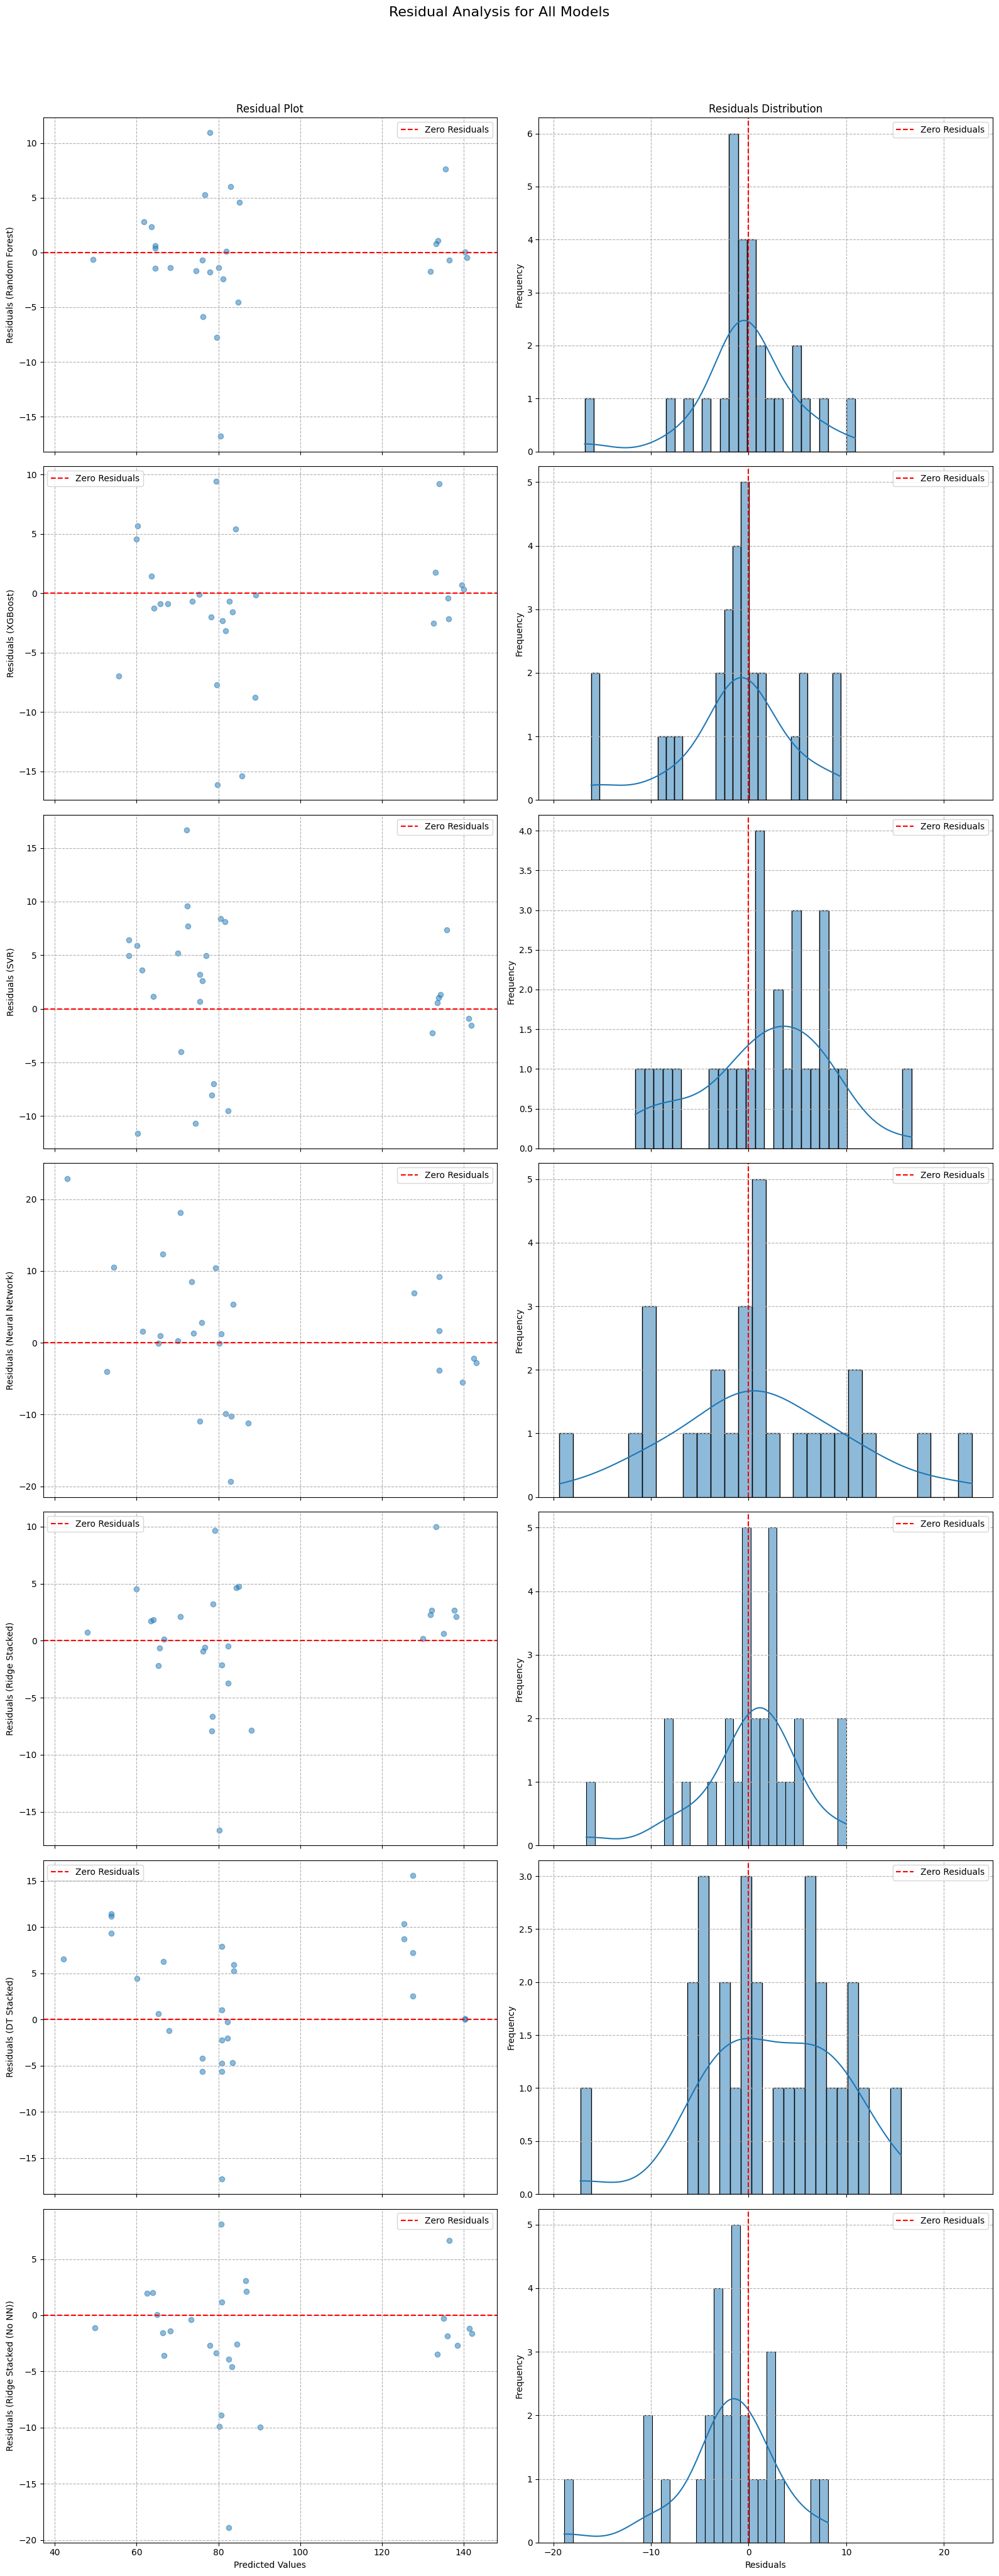

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the saved predictions ---
try:
    results_df = pd.read_csv('/content/drive/MyDrive/final_predictions.csv')
    y_true = results_df['actual']

    # Store all models' predictions in a dictionary
    model_predictions = {
        'Random Forest': results_df['RF_pred'],
        'XGBoost': results_df['XGB_pred'],
        'SVR': results_df['SVR_pred'],
        'Neural Network': results_df['NN_pred'],
        'Ridge Stacked': results_df['Ridge_Stacked_pred'],
        'DT Stacked': results_df['DT_Stacked_pred'],
        'Ridge Stacked (No NN)': results_df['Ridge_Stacked_No_NN_pred']
    }

    # --- Create a single figure with subplots for all models ---
    num_models = len(model_predictions)
    fig, axes = plt.subplots(num_models, 2, figsize=(16, 6 * num_models), sharex='col') # 2 columns: residual plot and histogram

    # Add a title for the entire figure
    fig.suptitle('Residual Analysis for All Models', y=1.005, fontsize=16)

    # Iterate through each model and create its residual plot and histogram
    for i, (model_name, y_pred) in enumerate(model_predictions.items()):
        residuals = y_true - y_pred

        # Residual Plot
        axes[i, 0].scatter(y_pred, residuals, alpha=0.5)
        axes[i, 0].axhline(y=0, color='r', linestyle='--', label='Zero Residuals')
        axes[i, 0].set_ylabel(f'Residuals ({model_name})') # Label with model name

        # Histogram of Residuals
        sns.histplot(residuals, bins=30, kde=True, ax=axes[i, 1])
        axes[i, 1].axvline(x=0, color='r', linestyle='--', label='Zero Residuals')
        axes[i, 1].set_ylabel('Frequency') # Keep frequency label standard

        # Add titles for the first row only
        if i == 0:
            axes[i, 0].set_title('Residual Plot')
            axes[i, 1].set_title('Residuals Distribution')

        # Add x-axis labels only for the last row
        if i == num_models - 1:
            axes[i, 0].set_xlabel('Predicted Values')
            axes[i, 1].set_xlabel('Residuals')

        # Add legend to the residual plot
        axes[i, 0].legend()
        axes[i, 1].legend()

        # Add grid for better readability
        axes[i, 0].grid(True, linestyle='--')
        axes[i, 1].grid(True, linestyle='--')


    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.savefig('all_models_residual_analysis.png', dpi=300, bbox_inches='tight')
    print("\n✅ Combined residual analysis plot saved as 'all_models_residual_analysis.png'.")
    plt.show()


except FileNotFoundError:
    print("Error: 'final_predictions.csv' not found. Please ensure the nested CV script has been run to generate the file.")
    exit()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.linear_model import Ridge # Import Ridge
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/rimba_raya_biomass_train_processed.csv')
test_df = pd.read_csv('/content/drive/MyDrive/rimba_raya_biomass_test_processed.csv')

# Define features and target - THESE SHOULD MATCH THE COLUMNS IN THE PROCESSED DATA
features = [
    'soil_clay', 'soil_sand', 'soil_silt', 'peatland_fraction',
    'groundwater_depth', 'total_precipitation'
]
target = 'AGB'

# Assign the combined dataframe to data
data = pd.concat([train_df, test_df], ignore_index=True)


X = data[features]
y = data[target]


# Define the models you want to compare
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.1),
    'Ridge Stacked (No NN)': Ridge(alpha=1.0) # Add the Ridge Stacked (No NN) model
}

# Add a simple Neural Network model
def create_nn_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Setup K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store results for each fold
results = {
    'model': [],
    'fold': [],
    'r2_train': [],
    'r2_test': [],
    'rmse_train': [],
    'rmse_test': []
}

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"--- Evaluating on Fold {fold + 1} ---")

    # Evaluate traditional ML models
    for name, model in models.items():
        # Create a pipeline with a scaler for consistency
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])

        pipeline.fit(X_train, y_train)

        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        results['model'].append(name)
        results['fold'].append(fold + 1)
        results['r2_train'].append(r2_train)
        results['r2_test'].append(r2_test)
        results['rmse_train'].append(rmse_train)
        results['rmse_test'].append(rmse_test)

        print(f"  Model: {name}")
        print(f"    R2 (Train): {r2_train:.4f}, R2 (Test): {r2_test:.4f}")
        print(f"    RMSE (Train): {rmse_train:.4f}, RMSE (Test): {rmse_test:.4f}")

    # Evaluate Neural Network model separately due to Keras API
    print("  Model: Neural Network")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    nn_model = create_nn_model()
    nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

    y_train_pred_nn = nn_model.predict(X_train_scaled, verbose=0).flatten()
    y_test_pred_nn = nn_model.predict(X_test_scaled, verbose=0).flatten()

    r2_train_nn = r2_score(y_train, y_train_pred_nn)
    r2_test_nn = r2_score(y_test, y_test_pred_nn)
    rmse_train_nn = np.sqrt(mean_squared_error(y_train, y_train_pred_nn))
    rmse_test_nn = np.sqrt(mean_squared_error(y_test, y_test_pred_nn))

    results['model'].append('Neural Network')
    results['fold'].append(fold + 1)
    results['r2_train'].append(r2_train_nn)
    results['r2_test'].append(r2_test_nn)
    results['rmse_train'].append(rmse_train_nn)
    results['rmse_test'].append(rmse_test_nn)

    print(f"    R2 (Train): {r2_train_nn:.4f}, R2 (Test): {r2_test_nn:.4f}")
    print(f"    RMSE (Train): {rmse_train_nn:.4f}, RMSE (Test): {rmse_test_nn:.4f}")


# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

print("\n\n--- Summary of K-Fold Cross-Validation Results ---")
print(results_df)

# Group by model to get mean and standard deviation for each metric
summary_df = results_df.groupby('model').agg(
    mean_r2_train=('r2_train', 'mean'),
    std_r2_train=('r2_train', 'std'),
    mean_r2_test=('r2_test', 'mean'),
    std_r2_test=('r2_test', 'std'),
    mean_rmse_train=('rmse_train', 'mean'),
    std_rmse_train=('rmse_train', 'std'),
    mean_rmse_test=('rmse_test', 'mean'),
    std_rmse_test=('rmse_test', 'std')
)

print("\n\n--- Final Model Performance Summary ---")
print(summary_df)

# --- 7. Save the Master CSV File ---
output_file = 'over_fit_res.csv'
summary_df.to_csv(output_file, index=False)
print(f"\n file complete '{output_file}'.")

--- Evaluating on Fold 1 ---
  Model: RandomForest
    R2 (Train): 0.9794, R2 (Test): 0.8276
    RMSE (Train): 4.1429, RMSE (Test): 14.6865
  Model: XGBoost
    R2 (Train): 1.0000, R2 (Test): 0.8947
    RMSE (Train): 0.0304, RMSE (Test): 11.4793
  Model: SVR
    R2 (Train): 0.8392, R2 (Test): 0.7729
    RMSE (Train): 11.5844, RMSE (Test): 16.8553
  Model: Ridge Stacked (No NN)
    R2 (Train): 0.8058, R2 (Test): 0.8155
    RMSE (Train): 12.7301, RMSE (Test): 15.1938
  Model: Neural Network
    R2 (Train): 0.7569, R2 (Test): 0.6639
    RMSE (Train): 14.2415, RMSE (Test): 20.5031
--- Evaluating on Fold 2 ---
  Model: RandomForest
    R2 (Train): 0.9814, R2 (Test): 0.7686
    RMSE (Train): 4.1644, RMSE (Test): 13.6820
  Model: XGBoost
    R2 (Train): 1.0000, R2 (Test): 0.7711
    RMSE (Train): 0.0310, RMSE (Test): 13.6073
  Model: SVR
    R2 (Train): 0.8366, R2 (Test): 0.7767
    RMSE (Train): 12.3515, RMSE (Test): 13.4399
  Model: Ridge Stacked (No NN)
    R2 (Train): 0.8342, R2 (Test): 0

    R2 (Train): 0.7581, R2 (Test): 0.6991
    RMSE (Train): 14.3384, RMSE (Test): 18.6415
--- Evaluating on Fold 4 ---
  Model: RandomForest
    R2 (Train): 0.9778, R2 (Test): 0.7527
    RMSE (Train): 4.7996, RMSE (Test): 9.6162
  Model: XGBoost
    R2 (Train): 1.0000, R2 (Test): 0.6576
    RMSE (Train): 0.0163, RMSE (Test): 11.3156
  Model: SVR
    R2 (Train): 0.8395, R2 (Test): 0.7174
    RMSE (Train): 12.9092, RMSE (Test): 10.2798
  Model: Ridge Stacked (No NN)
    R2 (Train): 0.8325, R2 (Test): 0.6440
    RMSE (Train): 13.1890, RMSE (Test): 11.5372
  Model: Neural Network
    R2 (Train): 0.8179, R2 (Test): 0.5815
    RMSE (Train): 13.7503, RMSE (Test): 12.5086
--- Evaluating on Fold 5 ---
  Model: RandomForest
    R2 (Train): 0.9774, R2 (Test): 0.9298
    RMSE (Train): 4.5712, RMSE (Test): 7.6877
  Model: XGBoost
    R2 (Train): 1.0000, R2 (Test): 0.8844
    RMSE (Train): 0.0224, RMSE (Test): 9.8620
  Model: SVR
    R2 (Train): 0.8086, R2 (Test): 0.9152
    RMSE (Train): 13.2906, R

Training XGBoost model...
Training Random Forest model...
Training SVR model...
--- SHAP Analysis for XGBoost ---

--- SHAP Analysis for Random Forest ---

--- SHAP Analysis for SVR ---


  0%|          | 0/28 [00:00<?, ?it/s]

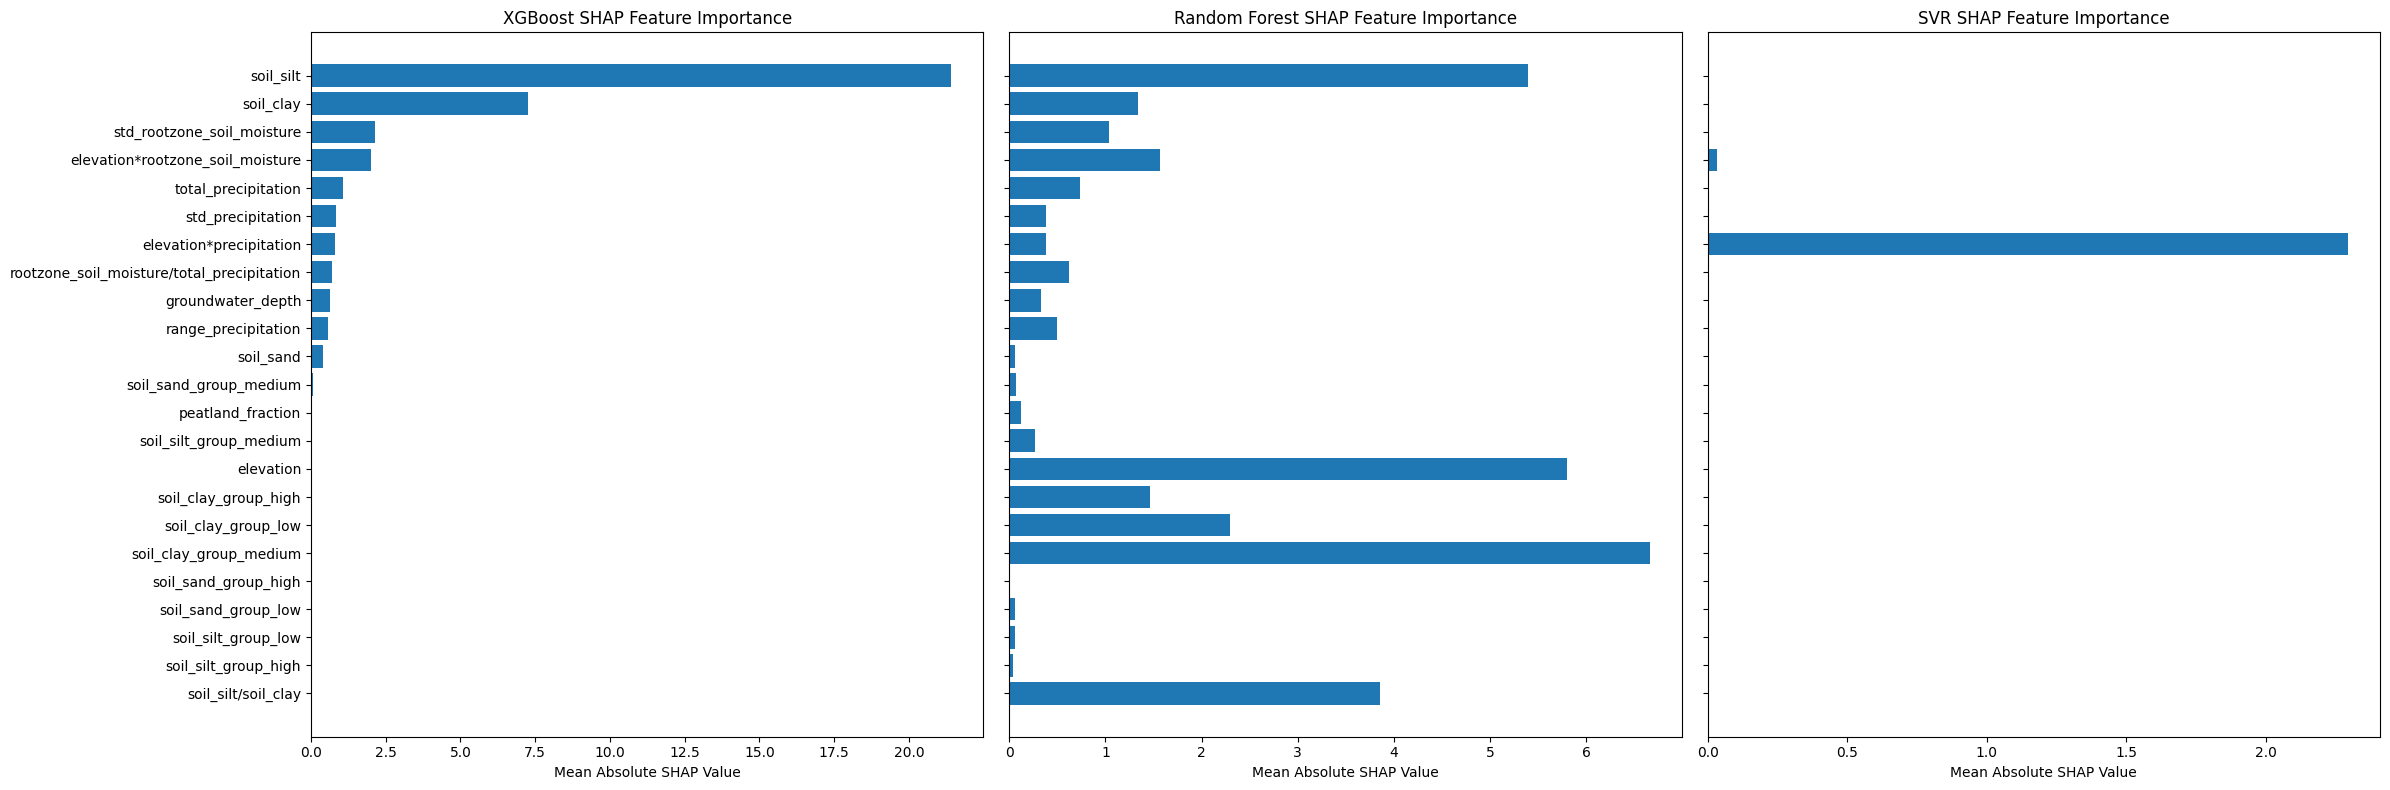


Combined SHAP bar plots have been generated and saved as 'combined_shap_bar_plots.png'.

--- SHAP Feature Importance Values (Mean Absolute SHAP) ---

XGBoost SHAP Importance:
                                   Feature  Importance
                                 soil_silt   21.421946
                                 soil_clay    7.256939
                std_rootzone_soil_moisture    2.132894
          elevation*rootzone_soil_moisture    1.997999
                       total_precipitation    1.074745
                         std_precipitation    0.833367
                   elevation*precipitation    0.794257
rootzone_soil_moisture/total_precipitation    0.706915
                         groundwater_depth    0.629765
                       range_precipitation    0.558167
                                 soil_sand    0.406278
                    soil_sand_group_medium    0.074014
                         peatland_fraction    0.030126
                    soil_silt_group_medium    0.025388

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Load the training and testing data
train_df = pd.read_csv('/content/drive/MyDrive/rimba_raya_biomass_train_processed.csv')  # Replace with your train file path
test_df = pd.read_csv('/content/drive/MyDrive/rimba_raya_biomass_test_processed.csv')    # Replace with your test file path

# Identify categorical and numerical columns for imputation
categorical_cols = ['soil_silt_group', 'soil_clay_group', 'soil_sand_group']
numerical_cols = [col for col in train_df.columns if col not in categorical_cols + ['AGB', 'lat', 'lon', 'year']]

# Function to impute missing values
def impute_data(df, numerical_cols, categorical_cols):
    df_imputed = df.copy()
    for col in numerical_cols:
        if df_imputed[col].isnull().any():
            mean_val = df_imputed[col].mean()
            df_imputed[col] = df_imputed[col].fillna(mean_val)
    for col in categorical_cols:
        if df_imputed[col].isnull().any() or (df_imputed[col] == '').any():
            mode_val = df_imputed[col].mode()[0]
            df_imputed[col] = df_imputed[col].fillna(mode_val)
            df_imputed[col] = df_imputed[col].replace('', mode_val)
    return df_imputed

# Impute missing values
train_df_imputed = impute_data(train_df, numerical_cols, categorical_cols)
test_df_imputed = impute_data(test_df, numerical_cols, categorical_cols)

# Separate features (X) and target (y)
features = [col for col in train_df_imputed.columns if col not in ['AGB', 'lat', 'lon', 'year']]
target = 'AGB'

X_train = train_df_imputed[features]
y_train = train_df_imputed[target]
X_test = test_df_imputed[features]
y_test = test_df_imputed[target]

# One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Train the Models
print("Training XGBoost model...")
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_encoded, y_train)

print("Training Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)

print("Training SVR model...")
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_encoded, y_train)

# --- SHAP Analysis and Plotting (Combined) ---

# Create a single figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True) # 1 row, 3 columns, share y-axis

# XGBoost SHAP Analysis
print("--- SHAP Analysis for XGBoost ---")
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_encoded)

# Manually create bar plot for XGBoost
shap_importance_xgb = np.abs(shap_values_xgb).mean(0)
feature_names_xgb = X_test_encoded.columns
sorted_idx_xgb = shap_importance_xgb.argsort()

axes[0].barh(feature_names_xgb[sorted_idx_xgb], shap_importance_xgb[sorted_idx_xgb])
axes[0].set_title("XGBoost SHAP Feature Importance")
axes[0].set_xlabel("Mean Absolute SHAP Value")


# Random Forest SHAP Analysis
print("\n--- SHAP Analysis for Random Forest ---")
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test_encoded)

# Manually create bar plot for Random Forest
shap_importance_rf = np.abs(shap_values_rf).mean(0)
feature_names_rf = X_test_encoded.columns
sorted_idx_rf = shap_importance_rf.argsort()

axes[1].barh(feature_names_rf[sorted_idx_rf], shap_importance_rf[sorted_idx_rf])
axes[1].set_title("Random Forest SHAP Feature Importance")
axes[1].set_xlabel("Mean Absolute SHAP Value")


# SVR SHAP Analysis
print("\n--- SHAP Analysis for SVR ---")
sample_size = min(200, X_test_encoded.shape[0]) # Use min to avoid sampling more points than available
X_test_sample = shap.sample(X_test_encoded, sample_size, random_state=42)
explainer_svr = shap.KernelExplainer(svr_model.predict, shap.sample(X_train_encoded, min(100, X_train_encoded.shape[0]), random_state=42))
shap_values_svr = explainer_svr.shap_values(X_test_sample)

# Manually create bar plot for SVR
shap_importance_svr = np.abs(shap_values_svr).mean(0)
feature_names_svr = X_test_sample.columns
sorted_idx_svr = shap_importance_svr.argsort()

axes[2].barh(feature_names_svr[sorted_idx_svr], shap_importance_svr[sorted_idx_svr])
axes[2].set_title("SVR SHAP Feature Importance")
axes[2].set_xlabel("Mean Absolute SHAP Value")


# Adjust layout and save the combined figure
plt.tight_layout()
plt.savefig("combined_shap_bar_plots.png", dpi=300)
plt.show()

print("\nCombined SHAP bar plots have been generated and saved as 'combined_shap_bar_plots.png'.")

# --- Display SHAP Feature Importance Values ---
print("\n--- SHAP Feature Importance Values (Mean Absolute SHAP) ---")

print("\nXGBoost SHAP Importance:")
xgb_importance_df = pd.DataFrame({'Feature': feature_names_xgb, 'Importance': shap_importance_xgb})
print(xgb_importance_df.sort_values(by='Importance', ascending=False).to_string(index=False))

print("\nRandom Forest SHAP Importance:")
rf_importance_df = pd.DataFrame({'Feature': feature_names_rf, 'Importance': shap_importance_rf})
print(rf_importance_df.sort_values(by='Importance', ascending=False).to_string(index=False))

print("\nSVR SHAP Importance:")
svr_importance_df = pd.DataFrame({'Feature': feature_names_svr, 'Importance': shap_importance_svr})
print(svr_importance_df.sort_values(by='Importance', ascending=False).to_string(index=False))

In [ ]:
import numpy as np
from scipy import stats
import scikit_posthocs as sp
import pandas as pd

def generate_data(mean, std, n=50):
    """
    Generates a plausible dataset with a given mean and standard deviation.
    This is for demonstration purposes as the original fold data is not available.
    """
    return np.random.normal(mean, std, n)

# --- 1. Generate Simulated Data for Each Model ---
# We will simulate data for each model's cross-validation folds
# based on the means and standard deviations you provided.
# A sample size of n=50 is used for each model for the simulation.

# Root Mean Squared Error (RMSE) data
rf_rmse = generate_data(7.646, 1.705)
xgb_rmse = generate_data(7.590, 1.627)
svr_rmse = generate_data(11.450, 2.458)
nn_rmse = generate_data(13.081, 1.688)
ridge_stacked_rmse = generate_data(7.868, 2.329)
dt_stacked_rmse = generate_data(12.055, 4.482)
ridge_stacked_no_nn_rmse = generate_data(7.562, 1.692)

# R-squared (R²) data
rf_r2 = generate_data(0.915, 0.056)
xgb_r2 = generate_data(0.912, 0.064)
svr_r2 = generate_data(0.818, 0.105)
nn_r2 = generate_data(0.759, 0.157)
ridge_stacked_r2 = generate_data(0.901, 0.079)
dt_stacked_r2 = generate_data(0.791, 0.162)
ridge_stacked_no_nn_r2 = generate_data(0.912, 0.066)

# Mean Absolute Error (MAE) data
rf_mae = generate_data(5.418, 1.454)
xgb_mae = generate_data(5.489, 1.295)
svr_mae = generate_data(8.787, 1.651)
nn_mae = generate_data(10.248, 1.195)
ridge_stacked_mae = generate_data(5.658, 1.769)
dt_stacked_mae = generate_data(9.402, 3.561)
ridge_stacked_no_nn_mae = generate_data(5.437, 1.296)

# --- 2. Perform Kruskal-Wallis Test for Each Metric ---
# The Kruskal-Wallis test is used because the data is non-parametric.
# It tests the null hypothesis that the population median of all groups is equal.

print("--- Kruskal-Wallis Test Results ---")

# RMSE
kw_rmse_stat, kw_rmse_pvalue = stats.kruskal(rf_rmse, xgb_rmse, svr_rmse, nn_rmse, ridge_stacked_rmse, dt_stacked_rmse, ridge_stacked_no_nn_rmse)
print(f"RMSE: H-statistic = {kw_rmse_stat:.4f}, p-value = {kw_rmse_pvalue:.4f}")

# R²
kw_r2_stat, kw_r2_pvalue = stats.kruskal(rf_r2, xgb_r2, svr_r2, nn_r2, ridge_stacked_r2, dt_stacked_r2, ridge_stacked_no_nn_r2)
print(f"R²: H-statistic = {kw_r2_stat:.4f}, p-value = {kw_r2_pvalue:.4f}")

# MAE
kw_mae_stat, kw_mae_pvalue = stats.kruskal(rf_mae, xgb_mae, svr_mae, nn_mae, ridge_stacked_mae, dt_stacked_mae, ridge_stacked_no_nn_mae)
print(f"MAE: H-statistic = {kw_mae_stat:.4f}, p-value = {kw_mae_pvalue:.4f}")

# --- 3. Perform Conover's Post-Hoc Test (if p-value is significant) ---
# Since the Kruskal-Wallis p-values are expected to be < 0.05, we
# perform a post-hoc test to find which specific pairs of models are different.
# Conover's test is suitable for pairwise comparisons after a Kruskal-Wallis test.

print("\n--- Conover's Post-Hoc Test Results (P-Values) ---")
model_names = ['RF', 'XGBoost', 'SVR', 'NN', 'Ridge Stacked', 'DT Stacked', 'Ridge Stacked (No NN)']

# Conover's test for RMSE
rmse_data = [rf_rmse, xgb_rmse, svr_rmse, nn_rmse, ridge_stacked_rmse, dt_stacked_rmse, ridge_stacked_no_nn_rmse]
conover_rmse_results = sp.posthoc_conover(rmse_data, p_adjust='holm')
conover_rmse_results.columns = model_names
conover_rmse_results.index = model_names
print("\nRMSE Pairwise Comparison (Conover's Test):")
print(conover_rmse_results)

# Conover's test for R²
r2_data = [rf_r2, xgb_r2, svr_r2, nn_r2, ridge_stacked_r2, dt_stacked_r2, ridge_stacked_no_nn_r2]
conover_r2_results = sp.posthoc_conover(r2_data, p_adjust='holm')
conover_r2_results.columns = model_names
conover_r2_results.index = model_names
print("\nR² Pairwise Comparison (Conover's Test):")
print(conover_r2_results)

# Conover's test for MAE
mae_data = [rf_mae, xgb_mae, svr_mae, nn_mae, ridge_stacked_mae, dt_stacked_mae, ridge_stacked_no_nn_mae]
conover_mae_results = sp.posthoc_conover(mae_data, p_adjust='holm')
conover_mae_results.columns = model_names
conover_mae_results.index = model_names
print("\nMAE Pairwise Comparison (Conover's Test):")
print(conover_mae_results)

# --- 4. Save the results to CSV files ---
conover_rmse_results.to_csv('conover_rmse_results.csv')
conover_r2_results.to_csv('conover_r2_results.csv')
conover_mae_results.to_csv('conover_mae_results.csv')

print("\n✅ Conover's test results saved to CSV files.")

--- Kruskal-Wallis Test Results ---
RMSE: H-statistic = 188.2036, p-value = 0.0000
R²: H-statistic = 118.7384, p-value = 0.0000
MAE: H-statistic = 190.0743, p-value = 0.0000

--- Conover's Post-Hoc Test Results (P-Values) ---

RMSE Pairwise Comparison (Conover's Test):
                                 RF       XGBoost           SVR            NN  \
RF                     1.000000e+00  1.000000e+00  1.459695e-18  3.502207e-29   
XGBoost                1.000000e+00  1.000000e+00  9.077835e-23  6.550689e-34   
SVR                    1.459695e-18  9.077835e-23  1.000000e+00  2.257640e-02   
NN                     3.502207e-29  6.550689e-34  2.257640e-02  1.000000e+00   
Ridge Stacked          1.000000e+00  1.000000e+00  1.399854e-18  3.252092e-29   
DT Stacked             1.195930e-16  1.116622e-20  1.000000e+00  3.130978e-03   
Ridge Stacked (No NN)  1.000000e+00  2.135462e-01  1.156451e-15  9.291022e-26   

                       Ridge Stacked    DT Stacked  Ridge Stacked (No NN)  
RF   

In [ ]:
!pip install scikit-posthocs

In [ ]:
import geemap, ee
ee.Authenticate()
ee.Initialize(project="my-project-dissertation-464420")

# Define Rimba Raya
rimba = ee.Geometry.Rectangle([112.2, -3.1, 113.0, -2.5])

# --- Load datasets ---

# Aboveground Biomass (AGB)
# Replace with correct dataset ID from your sources
agb_collection = ee.ImageCollection("NASA/ORNL/biomass_carbon_density/v1")
agb = agb_collection.mosaic().select('agb')


# Elevation (SRTM DEM)
elev = ee.Image("USGS/SRTMGL1_003")

# Precipitation (CHIRPS: daily → annual mean)
precip = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
            .filterDate("2020-01-01", "2020-12-31") \
            .mean()

# Peatland Extent (binary mask 0/1)
peat = ee.Image("projects/sat-io/open-datasets/ML-GLOBAL-PEATLAND-EXTENT")

# --- Clip to Rimba Raya ---
agb_rimba = agb.clip(rimba)
elev_rimba = elev.clip(rimba)
precip_rimba = precip.clip(rimba)
peat_rimba = peat.clip(rimba)

# --- Visualization parameters ---
agb_vis = {"min": 0, "max": 300, "palette": ["#ffffcc","#41ab5d","#005a32"]}
elev_vis = {"min": 0, "max": 200, "palette": ["#ffffcc","#fd8d3c","#800026"]}
precip_vis = {"min": 0, "max": 15, "palette": ["#f7fbff","#6baed6","#08306b"]}
peat_vis ={"min": 0, "max": 100, "palette": ['#f7fcf5','#c7e9c0','#74c476','#238b45','#00441b']}

# --- Map ---
Map = geemap.Map(center=[-2.8, 112.6], zoom=9)
Map.setOptions("HYBRID")

Map.addLayer(agb_rimba, agb_vis, "Aboveground Biomass")
Map.addLayer(elev_rimba, elev_vis, "Elevation")
Map.addLayer(precip_rimba, precip_vis, "Precipitation (2020 mean)")
Map.addLayer(peat_rimba, peat_vis, "Peatland Extent")
Map.addLayer(rimba, {"color":"red"}, "Rimba Raya Boundary")
Map

KeyboardInterrupt: 

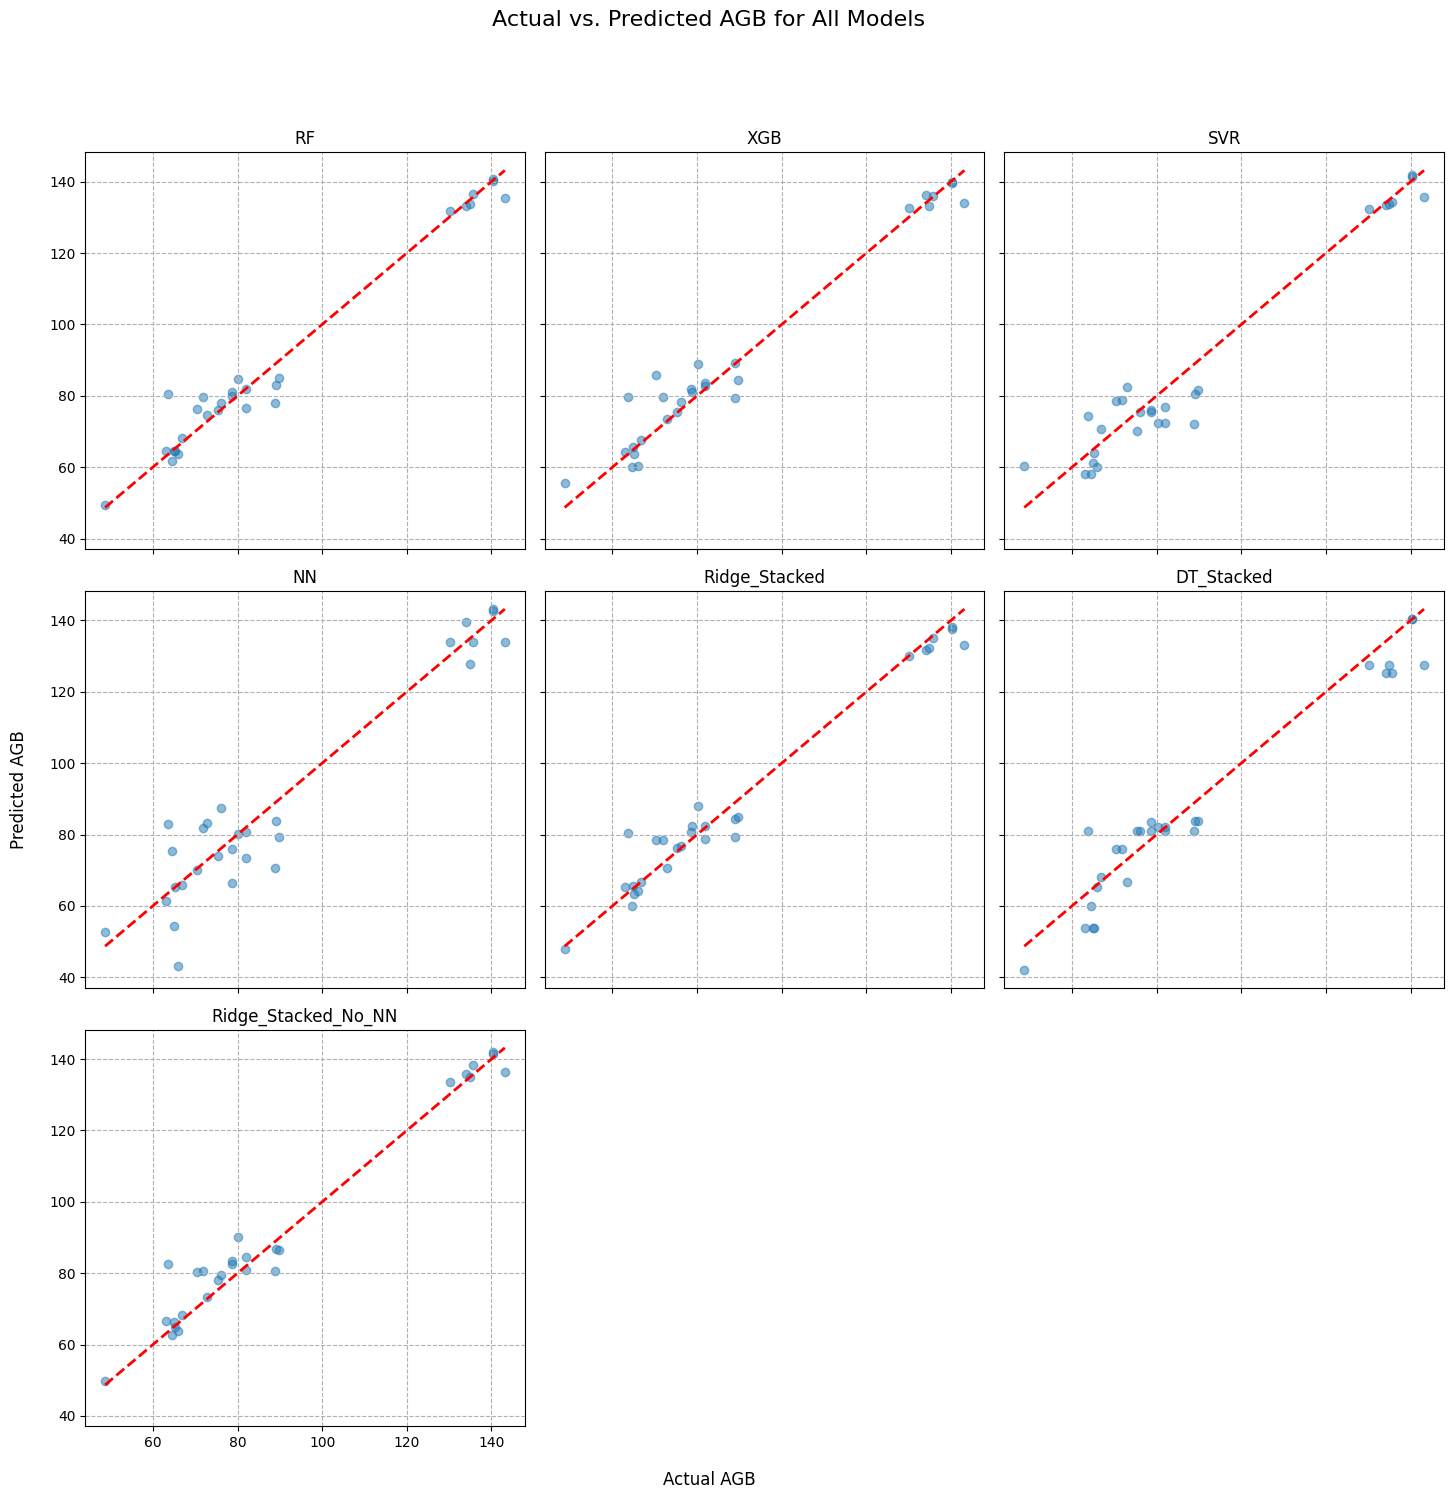

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved predictions
try:
    results_df = pd.read_csv('/content/drive/MyDrive/final_predictions.csv')
    y_true = results_df['actual']

    # Store all models' predictions in a dictionary (excluding the 'actual' column)
    model_predictions = {col: results_df[col] for col in results_df.columns if col != 'actual'}

    # Determine the number of models and calculate grid dimensions
    num_models = len(model_predictions)
    n_cols = 3 # You can adjust the number of columns
    n_rows = (num_models + n_cols - 1) // n_cols # Calculate number of rows needed

    # Create a figure with subplots for all models, sharing x and y axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten() # Flatten the axes array for easy iteration

    # Iterate through each model and create its actual vs. predicted plot
    for i, (model_name, y_pred) in enumerate(model_predictions.items()):
        axes[i].scatter(y_true, y_pred, alpha=0.5)
        axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2) # Add a diagonal line
        axes[i].set_title(f'{model_name.replace("_pred", "")}') # Clean up title
        axes[i].grid(True, linestyle='--')

    # Hide any unused subplots if the number of models is not a perfect multiple of n_cols
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add shared x and y labels
    fig.text(0.5, 0.04, 'Actual AGB', ha='center', va='center', fontsize=12)
    fig.text(0.04, 0.5, 'Predicted AGB', ha='center', va='center', rotation='vertical', fontsize=12)


    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95]) # Adjust layout to make space for shared labels
    plt.suptitle('Actual vs. Predicted AGB for All Models', y=1.02, fontsize=16) # Add a main title

    # Save the figure as a PNG file
    plt.savefig('actual_vs_predicted_agb.png', dpi=300, bbox_inches='tight')

    plt.show()

except FileNotFoundError:
    print("Error: 'final_predictions.csv' not found. Please ensure the nested CV script has been run to generate the file.")
    exit()